In [1061]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import sys
sys.path.append('thesis-2p-behavior-align/imaging/')
import imaging_behavior_functions_cleaned

def load_pro_mat_to_dataframe(file_path):
    """
    Load downsampled fields from a MATLAB v7.3 _pro.mat file into a pandas DataFrame.

    Parameters:
        file_path (str): Path to the _pro.mat file.

    Returns:
        pd.DataFrame: A DataFrame containing the downsampled fields.
    """
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Navigate to the 'exptData' group
        if 'exptData' not in f:
            raise ValueError(f"The file {file_path} does not contain 'exptData'.")
        
        expt_data = f['exptData']
        
        # List of fields to extract
        fields_to_include = [
            'tDS', 'optoStim', 'g4displayXPos','headingPosition', 'angularVelocity',
            'angularSpeed', 'forwardPosition', 'forwardVelocity',
            'sidewaysPosition', 'sidewaysVelocity', 'totSpeed', 'x', 'y'
        ]
        
        # Extract and flatten the fields
        data_dict = {}
        for field in fields_to_include:
            if field in expt_data:
                data_dict[field] = expt_data[field][()].flatten()
            else:
                raise KeyError(f"Field '{field}' is missing in 'exptData'.")
        data_dict['angularSpeed_radian'] = np.radians(data_dict['angularSpeed'])
    # Create DataFrame
    df = pd.DataFrame(data_dict)
    return df


def compute_prestimulus_vars(df, window_size):
    """
    Compute the prestimulus modal heading and prestimulus average of rho_t for each odor encounter.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'optoStim', 'g4display_col', and 'rho_t'.
    window_size (int): Number of rows before an odor onset to consider.
    
    Returns:
    pd.DataFrame: Updated DataFrame with 'prestimulus_modal_heading' and 'avergae_rho_t_pre' columns.
    """
    df['prestimulus_modal_heading'] = np.nan  # Initialize column for modal heading
    df['avergae_rho_t_pre'] = np.nan  # Initialize column for prestimulus average of rho_t
    
    odor_on_indices = df.index[df['optoStim'].diff() > 0].tolist()  # Find odor onset indices
    #print(odor_on_indices)
    
    for idx in odor_on_indices:
        start_idx = max(0, idx - window_size)
        # Define the prestimulus window for both g4display_col and rho_t
        pre_stimulus_window = df.loc[start_idx:idx - 1, 'g4displayXPos']
        pre_rho_window = df.loc[start_idx:idx - 1, 'rho_t']
        
        # Compute circular mode for prestimulus_modal_heading if window is not empty
        if not pre_stimulus_window.empty:
            #print(pre_stimulus_window.values)
            #print(circular_mode(pre_stimulus_window.values))
            df.at[idx, 'prestimulus_modal_heading'] = imaging_behavior_functions_cleaned.circular_mode(pre_stimulus_window.dropna().values,method='histogram')
        
        # Compute average for rho_t if window is not empty
        if not pre_rho_window.empty:
            df.at[idx, 'avergae_rho_t_pre'] = pre_rho_window.mean()
    
    return df


def load_all_pro_mat_files_to_df(directory_path,window_size=50):
    """
    Loop through all _pro.mat files in a directory and create a combined DataFrame.

    Parameters:
        directory_path (str): Path to the directory containing _pro.mat files.

    Returns:
        pd.DataFrame: A combined DataFrame with data from all files, including columns for file names, file IDs, and fly IDs.
    """
    combined_df = pd.DataFrame()
    fileid = 0  # Initialize file ID
    flyid = 0  # Initialize fly ID
    unique_fly_combinations = {}  # Dictionary to track unique combinations of date and fly number

    # Loop through all .mat files in the directory
    for file_name in os.listdir(directory_path):
        if file_name.endswith('_pro.mat'):
            file_path = os.path.join(directory_path, file_name)
            print(f"Loading file: {file_path}")

            #try:
                # Load the .mat file into a DataFrame
            df = load_pro_mat_to_dataframe(file_path)
            # update by adding theta_g and rho_t
            df = calculate_theta_g_rho(df)
            df = compute_prestimulus_vars(df,window_size)

            # Add a column for the file name
            df['fileName'] = file_name

            # Add a column for the file ID
            df['fileid'] = fileid
            df['modal_heading'] = imaging_behavior_functions_cleaned.circular_mode(df['g4displayXPos'],method='histogram')

            # Calculate avg_rho_t (average over all time)
            df['avg_rho_t'] = df['rho_t'].mean()

            # Calculate avg_rho_t_initial (average over time <= 50 sec)
            df['avg_rho_t_initial'] = df.loc[df['tDS'] <= 50, 'rho_t'].mean()

            # Extract the date and fly number from the file name
            # Assumes the file name contains "_YYYY_MM_DD_flyXX_"
            match = re.search(r'_(\d{4}_\d{2}_\d{2})_fly(\d+)_', file_name)
            if match:
                date = match.group(1)  # Extracted date
                fly_number = int(match.group(2))  # Extracted fly number
                combination = (date, fly_number)

                # Check if the combination is unique
                if combination not in unique_fly_combinations:
                    unique_fly_combinations[combination] = flyid
                    flyid += 1

                # Assign the corresponding flyid
                df['flyid'] = unique_fly_combinations[combination]
            else:
                df['flyid'] = None  # Assign None if date or fly number is not found

            # Append the DataFrame to the combined DataFrame
            combined_df = pd.concat([combined_df, df], ignore_index=True)

            # Increment the file ID
            fileid += 1
            #except Exception as e:
                #print(f"Error loading file {file_name}: {e}")

    return combined_df



def calculate_theta_g_rho(df, window_size=5000, speed_threshold=1):
    """
    Calculate the goal direction (theta_g) and consistency of head direction (rho_t) for each time point.
    
    Parameters:
    - df: DataFrame containing 'forward', 'side', 'yaw', and 'heading' columns (time series of a trial).
    - window_size: The size of the window in seconds to compute the rolling statistics.
    - speed_threshold: Speed threshold below which the fly is considered standing still.
    
    Returns:
    - A DataFrame with 'theta_g' and 'rho_t' columns added (same length as input).
    """
    # Ensure 'totSpeed' and 'g4displayXPos' are valid
    if 'totSpeed' not in df.columns or 'g4displayXPos' not in df.columns:
        raise ValueError("The DataFrame must contain 'totSpeed' and 'g4displayXPos' columns.")
    
    # Compute the rolling sums for sin and cos of g4displayXPos
    df['sin_head'] = np.sin(df['g4displayXPos'])
    df['cos_head'] = np.cos(df['g4displayXPos'])

    # Apply rolling sum only for valid rows where totSpeed > speed_threshold
    valid_rows = df['totSpeed'] > speed_threshold
    rolling_sin_sum = df.loc[valid_rows, 'sin_head'].rolling(window_size, center=True, min_periods=1).sum()
    rolling_cos_sum = df.loc[valid_rows, 'cos_head'].rolling(window_size, center=True, min_periods=1).sum()
    rolling_count = df.loc[valid_rows, 'sin_head'].rolling(window_size, center=True, min_periods=1).count()

    # Compute theta_g (goal direction) and rho_t (consistency)
    theta_g = np.arctan2(rolling_sin_sum, rolling_cos_sum) % (2 * np.pi)
    rho_t = np.sqrt((rolling_cos_sum / rolling_count) ** 2 + (rolling_sin_sum / rolling_count) ** 2)

    # Assign calculated values back to the DataFrame
    df['theta_g'] = np.nan
    df['rho_t'] = np.nan
    df.loc[valid_rows, 'theta_g'] = theta_g
    df.loc[valid_rows, 'rho_t'] = rho_t

    # Drop temporary columns used for calculations
    df.drop(columns=['sin_head', 'cos_head'], inplace=True)
    
    return df



def plot_opto_window_overlay_combined_flyavg(
    combined_df, 
    forward_velocity_col='forwardVelocity', 
    angular_speed_col='angularSpeed_radian', 
    opto_col='optoStim', 
    time_col='tDS', 
    file_id_col='fileid', 
    fly_id_col='flyid', 
    window=(-2, 3)
):
    """
    Overlay forward velocity and angular speed traces around multiple opto-stim onset windows for each fileID.
    Also plots the average trace for each fly and the overall average trace with thicker lines.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        angular_speed_col (str): Column name for angular speed.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()
    fly_avg_data = {}

    all_forward_velocity = []
    all_angular_speed = []
    all_times = []

    # Plotting setup
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'forward_velocity': [], 'angular_speed': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time
            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['forward_velocity'].append(window_df[forward_velocity_col].values)
                aligned_traces['angular_speed'].append(window_df[angular_speed_col].values)

        # Collect traces for averaging
        forward_velocity_array = np.array(aligned_traces['forward_velocity'])
        angular_speed_array = np.array(aligned_traces['angular_speed'])

        if forward_velocity_array.size > 0 and angular_speed_array.size > 0:
            avg_forward_velocity_file = np.nanmean(forward_velocity_array, axis=0)
            avg_angular_speed_file = np.nanmean(angular_speed_array, axis=0)

            # Accumulate averages by flyid
            fly_id = df[fly_id_col].iloc[0]
            if fly_id not in fly_avg_data:
                fly_avg_data[fly_id] = {'forward_velocity': [], 'angular_speed': [], 'time': []}

            fly_avg_data[fly_id]['forward_velocity'].append(avg_forward_velocity_file)
            fly_avg_data[fly_id]['angular_speed'].append(avg_angular_speed_file)
            fly_avg_data[fly_id]['time'].append(aligned_traces['time'][0])

            # Plot individual traces for this file
            for trace in aligned_traces['forward_velocity']:
                ax[0].plot(aligned_traces['time'][0], trace, color='blue', alpha=0.02)
            for trace in aligned_traces['angular_speed']:
                ax[1].plot(aligned_traces['time'][0], trace, color='green', alpha=0.02)

    # Plot averages by flyid
    for fly_id, fly_data in fly_avg_data.items():
        avg_forward_velocity_fly = np.nanmean(fly_data['forward_velocity'], axis=0)
        avg_angular_speed_fly = np.nanmean(fly_data['angular_speed'], axis=0)

        # Plot average traces for this fly
        ax[0].plot(fly_data['time'][0], avg_forward_velocity_fly, linewidth=1.5, color='blue', alpha=0.5, label=f'Fly {fly_id}')
        ax[1].plot(fly_data['time'][0], avg_angular_speed_fly, linewidth=1.5, color='green', alpha=0.5, label=f'Fly {fly_id}')

        # Append for overall averages
        all_forward_velocity.extend(fly_data['forward_velocity'])
        all_angular_speed.extend(fly_data['angular_speed'])
        all_times.extend(fly_data['time'])

    # Calculate overall averages
    forward_velocity_array = np.array(all_forward_velocity)
    angular_speed_array = np.array(all_angular_speed)
    avg_forward_velocity = np.nanmean(forward_velocity_array, axis=0)
    avg_angular_speed = np.nanmean(angular_speed_array, axis=0)

    # Plot overall average traces
    ax[0].plot(fly_data['time'][0], avg_forward_velocity, color='blue', linewidth=3, label='Overall Avg')
    ax[1].plot(fly_data['time'][0], avg_angular_speed, color='green', linewidth=3, label='Overall Avg')

    # Finalize plots
    ax[0].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].set_ylabel('Forward Velocity (units)')
    ax[0].set_ylim([-10, 25])
    ax[0].set_title('Forward Velocity Around Opto-Stim Onset')
    #ax[0].legend()

    ax[1].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular Speed (units)')
    ax[1].set_ylim([0, 10])
    ax[1].set_title('Angular Speed Around Opto-Stim Onset')
    #ax[1].legend()

    plt.tight_layout()
    plt.show()



def plot_opto_window_overlay_combined_singletrial(
    combined_df, 
    forward_velocity_col='forwardVelocity', 
    angular_speed_col='angularSpeed_radian', 
    opto_col='optoStim', 
    time_col='tDS', 
    file_id_col='fileid', 
    fly_id_col='flyid', 
    window=(-2, 3)
):
    """
    Overlay forward velocity and angular speed traces around multiple opto-stim onset windows for each fileID.
    Also plots the average trace for each fly and the overall average trace with thicker lines.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        angular_speed_col (str): Column name for angular speed.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()
    fly_avg_data = {}

    all_forward_velocity = []
    all_angular_speed = []
    all_times = []

    # Plotting setup
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    for file_id in unique_file_ids:
        print(file_id)
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'forward_velocity': [], 'angular_speed': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time
            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['forward_velocity'].append(window_df[forward_velocity_col].values)
                aligned_traces['angular_speed'].append(window_df[angular_speed_col].values)

        # Collect traces for averaging
        forward_velocity_array = np.array(aligned_traces['forward_velocity'])
        angular_speed_array = np.array(aligned_traces['angular_speed'])

        if forward_velocity_array.size > 0 and angular_speed_array.size > 0:
            avg_forward_velocity_file = np.nanmean(forward_velocity_array, axis=0)
            avg_angular_speed_file = np.nanmean(angular_speed_array, axis=0)

            # Accumulate averages by flyid
            fly_id = df[fly_id_col].iloc[0]
            if fly_id not in fly_avg_data:
                fly_avg_data[fly_id] = {'forward_velocity': [], 'angular_speed': [], 'time': []}

            fly_avg_data[fly_id]['forward_velocity'].append(avg_forward_velocity_file)
            fly_avg_data[fly_id]['angular_speed'].append(avg_angular_speed_file)
            fly_avg_data[fly_id]['time'].append(aligned_traces['time'][0])

            # Plot individual traces for this file
            for trace in aligned_traces['forward_velocity']:
                ax[0].plot(aligned_traces['time'][0], trace, color='blue', alpha=0.2)
            for trace in aligned_traces['angular_speed']:
                ax[1].plot(aligned_traces['time'][0], trace, color='green', alpha=0.2)

     # Plot averages by flyid
    for fly_id, fly_data in fly_avg_data.items():
        avg_forward_velocity_fly = np.nanmean(fly_data['forward_velocity'], axis=0)
        avg_angular_speed_fly = np.nanmean(fly_data['angular_speed'], axis=0)

        # Plot average traces for this fly
        #ax[0].plot(fly_data['time'][0], avg_forward_velocity_fly, linewidth=1.5, color='blue', alpha=0.5, label=f'Fly {fly_id}')
        #ax[1].plot(fly_data['time'][0], avg_angular_speed_fly, linewidth=1.5, color='green', alpha=0.5, label=f'Fly {fly_id}')

        # Append for overall averages
        all_forward_velocity.extend(fly_data['forward_velocity'])
        all_angular_speed.extend(fly_data['angular_speed'])
        all_times.extend(fly_data['time'])

    # Calculate overall averages
    forward_velocity_array = np.array(all_forward_velocity)
    angular_speed_array = np.array(all_angular_speed)
    avg_forward_velocity = np.nanmean(forward_velocity_array, axis=0)
    avg_angular_speed = np.nanmean(angular_speed_array, axis=0)

    # Plot overall average traces
    ax[0].plot(fly_data['time'][0], avg_forward_velocity, color='blue', linewidth=3, label='Overall Avg')
    ax[1].plot(fly_data['time'][0], avg_angular_speed, color='green', linewidth=3, label='Overall Avg')

    # Finalize plots
    ax[0].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].axvline(1, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].set_ylabel('Forward Velocity (units)')
    ax[0].set_ylim([-2, 15])
    ax[0].set_title('Forward Velocity Around Opto-Stim Onset')
    #ax[0].legend()

    ax[1].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].axvline(1, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular Speed (units)')
    ax[1].set_ylim([0, 2])
    ax[1].set_title('Angular Speed Around Opto-Stim Onset')
    #ax[1].legend()

    plt.tight_layout()
    plt.show()

def plot_opto_window_overlay_combined(
    combined_df, 
    forward_velocity_col='forwardVelocity', 
    angular_speed_col='angularSpeed_radian', 
    opto_col='optoStim', 
    time_col='tDS', 
    file_id_col='fileid', 
    fly_id_col='flyid', 
    window=(-2, 3), 
    threshold_forward_velocity=1.0, 
    threshold_angular_speed=0.5
):
    """
    Overlay forward velocity and angular speed traces around multiple opto-stim onset windows for each fileID.
    Also plots the average trace for each fly and the overall average trace with thicker lines.
    Optionally highlights traces where the pre-stimulus period velocity and speed are below thresholds.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        angular_speed_col (str): Column name for angular speed.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        window (tuple): Time window around opto-stim onset in seconds (start, end).
        threshold_forward_velocity (float): Threshold for average pre-stimulus forward velocity.
        threshold_angular_speed (float): Threshold for average pre-stimulus angular speed.

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()
    #print(len(unique_file_ids))
    fly_avg_data = {}

    all_forward_velocity_ok = []
    all_angular_speed_ok = []
    all_forward_velocity_not_ok = []
    all_angular_speed_not_ok = []
    all_times = []

    # Plotting setup
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fw_ok_count = 0
    fw_not_ok_count = 0

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'forward_velocity': [], 'angular_speed': [], 'pre_stim_ok': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time
            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            pre_stim_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] < 0)
            window_df = df[window_mask]

            if not window_df.empty:
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['forward_velocity'].append(window_df[forward_velocity_col].values)
                aligned_traces['angular_speed'].append(window_df[angular_speed_col].values)

                # Check pre-stimulus thresholds using the average
                pre_stim_df = df[pre_stim_mask]
                pre_stim_ok = (
                    pre_stim_df[forward_velocity_col].abs().mean() < threshold_forward_velocity and
                    pre_stim_df[angular_speed_col].abs().mean() < threshold_angular_speed
                )
                aligned_traces['pre_stim_ok'].append(pre_stim_ok)

        # Collect traces for averaging
        forward_velocity_array = np.array(aligned_traces['forward_velocity'])
        angular_speed_array = np.array(aligned_traces['angular_speed'])

        if forward_velocity_array.size > 0 and angular_speed_array.size > 0:
            # Separate traces based on pre-stimulus check
            for trace, pre_stim_ok in zip(forward_velocity_array, aligned_traces['pre_stim_ok']):
                if pre_stim_ok:
                    all_forward_velocity_ok.append(trace)
                else:
                    all_forward_velocity_not_ok.append(trace)
            fw_ok_count += len(all_forward_velocity_ok)
            fw_not_ok_count += len(all_forward_velocity_not_ok)
            for trace, pre_stim_ok in zip(angular_speed_array, aligned_traces['pre_stim_ok']):
                if pre_stim_ok:
                    all_angular_speed_ok.append(trace)
                else:
                    all_angular_speed_not_ok.append(trace)

            # Plot individual traces
            for trace, pre_stim_ok in zip(aligned_traces['forward_velocity'], aligned_traces['pre_stim_ok']):
                color = 'red' if pre_stim_ok else 'blue'
                alpha = 0.2 if pre_stim_ok else 0.05
                ax[0].plot(aligned_traces['time'][0], trace, color=color, alpha=0.05)
            for trace, pre_stim_ok in zip(aligned_traces['angular_speed'], aligned_traces['pre_stim_ok']):
                color = 'orange' if pre_stim_ok else 'green'
                alpha = 0.2 if pre_stim_ok else 0.05
                ax[1].plot(aligned_traces['time'][0], trace, color=color, alpha=0.05)
    print(fw_ok_count)
    print(fw_not_ok_count)
    # Calculate overall averages for pre-stim OK and not OK
    avg_forward_velocity_ok = np.nanmean(np.array(all_forward_velocity_ok), axis=0) if all_forward_velocity_ok else None
    avg_forward_velocity_not_ok = np.nanmean(np.array(all_forward_velocity_not_ok), axis=0) if all_forward_velocity_not_ok else None
    avg_angular_speed_ok = np.nanmean(np.array(all_angular_speed_ok), axis=0) if all_angular_speed_ok else None
    avg_angular_speed_not_ok = np.nanmean(np.array(all_angular_speed_not_ok), axis=0) if all_angular_speed_not_ok else None

    # Plot overall averages
    if avg_forward_velocity_ok is not None:
        ax[0].plot(aligned_traces['time'][0], avg_forward_velocity_ok, color='purple', linewidth=3, label='Overall Avg (Pre-Stim Not OK)')
    if avg_forward_velocity_not_ok is not None:
        ax[0].plot(aligned_traces['time'][0], avg_forward_velocity_not_ok, color='blue', linewidth=3, label='Overall Avg (Pre-Stim OK)')

    if avg_angular_speed_ok is not None:
        ax[1].plot(aligned_traces['time'][0], avg_angular_speed_ok, color='orange', linewidth=3, label='Overall Avg (Pre-Stim Not OK)')
    if avg_angular_speed_not_ok is not None:
        ax[1].plot(aligned_traces['time'][0], avg_angular_speed_not_ok, color='green', linewidth=3, label='Overall Avg (Pre-Stim OK)')

    # Finalize plots
    ax[0].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].axvline(1, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].set_ylabel('Forward Velocity (units)')
    ax[0].set_ylim([-2, 15])
    ax[0].set_title('Forward Velocity Around Opto-Stim Onset')
    ax[0].legend()

    ax[1].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].axvline(1, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular Speed (units)')
    ax[1].set_ylim([0, 2])
    ax[1].set_title('Angular Speed Around Opto-Stim Onset')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def plot_opto_window_overlay_combined_new_0(
    combined_df, 
    forward_velocity_col='forwardVelocity', 
    angular_speed_col='angularSpeed_radian', 
    opto_col='optoStim', 
    time_col='tDS', 
    file_id_col='fileid', 
    fly_id_col='flyid', 
    window=(-2, 3),
    forward_velocity_bounds=None,  # e.g., [0, 1, 2, 3]
    angular_speed_bounds=None      # e.g., [0, 0.5, 1, 1.5]
):
    """
    Overlay forward velocity and angular speed traces around opto-stim onset windows.
    Instead of plotting individual traces, this function bins events based on the pre-stimulus
    average values for forward velocity and angular speed using provided bounds and plots the 
    binned trace averages with shaded standard error regions.
    
    Parameters:
        combined_df (pd.DataFrame): DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        angular_speed_col (str): Column name for angular speed.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        window (tuple): Time window around opto-stim onset (start, end).
        forward_velocity_bounds (list or None): List of bin boundaries for pre-stimulus forward velocity.
        angular_speed_bounds (list or None): List of bin boundaries for pre-stimulus angular speed.
    
    Returns:
        None
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    # Lists to collect event traces and corresponding pre-stimulus means.
    all_forward_velocity_traces = []
    all_forward_velocity_prestim_means = []
    all_angular_speed_traces = []
    all_angular_speed_prestim_means = []
    common_time = None

    # Create the figure with two subplots.
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Loop through each file.
    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id].copy()

        # Detect opto-stim onset times.
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        # Process each opto onset event.
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time
            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            pre_stim_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] < 0)
            window_df = df[window_mask]

            if not window_df.empty:
                # Save the time vector (assumed to be the same for all events).
                if common_time is None:
                    common_time = window_df['aligned_time'].values

                # Get the forward velocity and angular speed traces.
                fv_trace = window_df[forward_velocity_col].values
                as_trace = window_df[angular_speed_col].values

                # Compute the pre-stimulus means.
                pre_stim_df = df[pre_stim_mask]
                fv_prestim_mean = pre_stim_df[forward_velocity_col].abs().mean() if not pre_stim_df.empty else np.nan
                as_prestim_mean = pre_stim_df[angular_speed_col].abs().mean() if not pre_stim_df.empty else np.nan

                # Save traces and corresponding pre-stim values.
                all_forward_velocity_traces.append(fv_trace)
                all_forward_velocity_prestim_means.append(fv_prestim_mean)
                all_angular_speed_traces.append(as_trace)
                all_angular_speed_prestim_means.append(as_prestim_mean)

    # Convert collected lists into numpy arrays.
    all_forward_velocity_traces = np.array(all_forward_velocity_traces)
    all_forward_velocity_prestim_means = np.array(all_forward_velocity_prestim_means)
    all_angular_speed_traces = np.array(all_angular_speed_traces)
    all_angular_speed_prestim_means = np.array(all_angular_speed_prestim_means)



    # Function to compute mean and standard error (SE) across events.
    def compute_mean_se(traces):
        mean_trace = np.nanmean(traces, axis=0)
        se_trace = np.nanstd(traces, axis=0) / np.sqrt(traces.shape[0])
        return mean_trace, se_trace

    # Binned averages for forward velocity.
    if forward_velocity_bounds is not None and len(forward_velocity_bounds) > 1:
        # Classify events into bins.
        forward_bins = np.digitize(all_forward_velocity_prestim_means, forward_velocity_bounds)
        #print(forward_bins)
        unique_bins = np.unique(forward_bins)
        #print(unique_bins)
        cmap = plt.get_cmap('rainbow', np.max(unique_bins))
        for i, b in enumerate(unique_bins):
            idx = forward_bins == b
            if np.sum(idx) > 0:
                mean_trace, se_trace = compute_mean_se(all_forward_velocity_traces[idx])
                # Label shows the bin range.
                if b - 1 < len(forward_velocity_bounds) - 1:
                    label = f'FV bin {b}: {forward_velocity_bounds[b-1]}-{forward_velocity_bounds[b]}'
                else:
                    label = f'FV bin {b}'
                ax[0].plot(common_time, mean_trace, color=cmap(i), linewidth=2, label=label)
                ax[0].fill_between(common_time, mean_trace - se_trace, mean_trace + se_trace, color=cmap(i), alpha=0.3)
    else:
        # Plot overall average if no bounds provided.
        if all_forward_velocity_traces.size > 0:
            mean_trace, se_trace = compute_mean_se(all_forward_velocity_traces)
            ax[0].plot(common_time, mean_trace, color='purple', linewidth=3, label='Overall FV Avg')
            ax[0].fill_between(common_time, mean_trace - se_trace, mean_trace + se_trace, color='purple', alpha=0.3)

    # Binned averages for angular speed.
    if angular_speed_bounds is not None and len(angular_speed_bounds) > 1:
        angular_bins = np.digitize(all_angular_speed_prestim_means, angular_speed_bounds,right=True)
        unique_bins = np.unique(angular_bins)
        cmap = plt.get_cmap('rainbow', np.max(unique_bins))
        for i, b in enumerate(unique_bins):
            idx = angular_bins == b
            if np.sum(idx) > 0:
                mean_trace, se_trace = compute_mean_se(all_angular_speed_traces[idx])
                if b - 1 < len(angular_speed_bounds) - 1:
                    label = f'AS bin {b}: {angular_speed_bounds[b-1]}-{angular_speed_bounds[b]}'
                else:
                    label = f'AS bin {b}'
                ax[1].plot(common_time, mean_trace, color=cmap(i), linewidth=2, label=label)
                ax[1].fill_between(common_time, mean_trace - se_trace, mean_trace + se_trace, color=cmap(i), alpha=0.3)
    else:
        if all_angular_speed_traces.size > 0:
            mean_trace, se_trace = compute_mean_se(all_angular_speed_traces)
            ax[1].plot(common_time, mean_trace, color='orange', linewidth=3, label='Overall AS Avg')
            ax[1].fill_between(common_time, mean_trace - se_trace, mean_trace + se_trace, color='orange', alpha=0.3)

    # Commented out individual trace plotting.
    # for trace in all_forward_velocity_traces:
    #     ax[0].plot(common_time, trace, color='gray', alpha=0.1)
    # for trace in all_angular_speed_traces:
    #     ax[1].plot(common_time, trace, color='gray', alpha=0.1)

    # Finalize the plots.
    ax[0].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].axvline(1, color='red', linestyle='--', label='Opto-Stim Offset')
    ax[0].set_ylabel('Forward Velocity (units)')
    ax[0].set_title('Forward Velocity Around Opto-Stim Onset')
    ax[0].set_ylim([0, 16])
    #ax[0].legend()

    ax[1].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].axvline(1, color='red', linestyle='--', label='Opto-Stim Offset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular Speed (units)')
    ax[1].set_title('Angular Speed Around Opto-Stim Onset')
    ax[1].set_ylim([0, 3])
    #ax[1].legend()

    plt.tight_layout()
    plt.show()

def plot_forward_velocity(combined_df, 
                          forward_velocity_col='forwardVelocity', 
                          opto_col='optoStim', 
                          time_col='tDS', 
                          file_id_col='fileid', 
                          window=(-2, 3),
                          forward_velocity_bounds=None,ax=None,color= (41/256,154/256,4/256)):
    """
    Plot forward velocity traces around opto-stim onset windows in a single plot.
    
    Optionally, bin events based on the pre-stimulus forward velocity average if 
    forward_velocity_bounds is provided.
    
    Parameters:
        combined_df (pd.DataFrame): DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        window (tuple): Time window around opto-stim onset (start, end).
        forward_velocity_bounds (list or None): Boundaries for binning pre-stimulus forward velocity.
            For example, [0, 1, 2, 3] will create bins: below 0, between 0–1, 1–2, 2–3, above 3.
    
    Returns:
        None
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Check required columns exist.
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()
    all_forward_velocity_traces = []
    all_forward_velocity_prestim_means = []
    common_time = None

    # Loop through each file.
    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id].copy()

        # Detect opto-stim onset times.
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values
        if len(opto_on_times) == 0:
            continue

        # Process each opto onset event.
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time
            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            pre_stim_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] < 0)
            window_df = df[window_mask]
            
            if not window_df.empty:
                # Save the common time vector (assumed identical for all events).
                if common_time is None:
                    common_time = window_df['aligned_time'].values
                
                # Extract forward velocity trace.
                fv_trace = window_df[forward_velocity_col].values
                all_forward_velocity_traces.append(fv_trace)
                
                # Compute pre-stimulus mean (absolute value).
                pre_stim_df = df[pre_stim_mask]
                fv_prestim_mean = pre_stim_df[forward_velocity_col].abs().mean() if not pre_stim_df.empty else np.nan
                all_forward_velocity_prestim_means.append(fv_prestim_mean)

    # Create a single plot.
    #fig, ax = plt.subplots(figsize=(10, 6))
    
    all_forward_velocity_traces = np.array(all_forward_velocity_traces)
    all_forward_velocity_prestim_means = np.array(all_forward_velocity_prestim_means)
    
    # If binning bounds are provided, group events and plot binned averages.
    if forward_velocity_bounds is not None:
        # Bin indices: values below the first bound get bin 0, values above the last bound get bin len(bins)
        bin_indices = np.digitize(all_forward_velocity_prestim_means, forward_velocity_bounds)
        unique_bins = np.unique(bin_indices)
        
        for b in unique_bins[1:2]:
            # Select events that fall in the current bin.
            bin_mask = bin_indices == b
            bin_traces = all_forward_velocity_traces[bin_mask]
            if bin_traces.size == 0:
                continue
            # Compute average and SEM.
            mean_trace = np.nanmean(bin_traces, axis=0)
            sem_trace = np.nanstd(bin_traces, axis=0) / np.sqrt(bin_traces.shape[0])
            
            # Create a label based on bin range.
            if b == 0:
                label = f"< {forward_velocity_bounds[0]}"
            elif b == len(forward_velocity_bounds):
                label = f">= {forward_velocity_bounds[-1]}"
            else:
                label = f"{forward_velocity_bounds[b-1]}-{forward_velocity_bounds[b]}"
            
            ax.plot(common_time, mean_trace, linewidth=2, color=color,alpha=0.8,label=f'Bin {label}')
            ax.fill_between(common_time, mean_trace - sem_trace, mean_trace + sem_trace, alpha=0.2, color=color)
    
    # If no binning is specified, plot overall average.
    else:
        if all_forward_velocity_traces.size > 0:
            mean_trace = np.nanmean(all_forward_velocity_traces, axis=0)
            sem_trace = np.nanstd(all_forward_velocity_traces, axis=0) / np.sqrt(all_forward_velocity_traces.shape[0])
            ax.plot(common_time, mean_trace, color='blue', linewidth=2, label='Mean Forward Velocity')
            ax.fill_between(common_time, mean_trace - sem_trace, mean_trace + sem_trace, 
                            color='blue', alpha=0.2, label='SEM')

    # Mark the opto-stim onset at time zero.
    ax.axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(forward_velocity_col)
    #ax.set_title('Forward Velocity Around Opto-Stim Onset')
    #ax.legend()
    #plt.show()
    return ax


def plot_opto_dots_by_velocity_bin(
    combined_df,
    forward_velocity_col='forwardVelocity',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    forward_velocity_bounds=None,  # e.g., [0, 1, 2, 3]
    window_length=1.0              # length of the window in seconds (default 1 sec)
):
    """
    For each trial (i.e. each opto event) compute three scalar averages from the forward
    velocity trace in three time windows:
      - Pre: immediately before opto onset: [-window_length, 0]
      - Stim: immediately after opto onset: [0, window_length]
      - Post: immediately after opto offset: [window_length, 2*window_length]
      
    Each trial is binned based on its pre-stimulus (pre) average using the provided 
    forward_velocity_bounds. Then, for each bin, trials are grouped by fly (using the 
    'flyid' column). For each fly the mean for each window is computed (if a fly has 
    multiple trials in the bin, its value is the average of those trials). Finally, a separate 
    subplot is created for each velocity bin where the individual fly data are shown as dots 
    (different color for pre, stim, post) along with a group error bar (mean ± standard error 
    computed from the fly-level averages).
    
    Parameters:
        combined_df (pd.DataFrame): DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        forward_velocity_bounds (list or None): List of bin boundaries for pre-stimulus forward velocity.
        window_length (float): Length of each time window (in seconds). Default is 1 sec.
    
    Returns:
        None
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Check for required columns.
    for col in [opto_col, time_col, fly_id_col]:
        if col not in combined_df.columns:
            raise KeyError(f"Column '{col}' is missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    # These lists will store trial-level data.
    all_pre_avg = []   # scalar: average forward velocity in pre-window (used for binning)
    all_stim_avg = []  # scalar: average in stim window
    all_post_avg = []  # scalar: average in post window
    all_fly_ids = []   # corresponding fly id for each trial

    # Loop over each file and each opto event.
    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id].copy()
        # Get fly id (assumes one fly per file).
        if fly_id_col not in df.columns:
            raise KeyError(f"Column '{fly_id_col}' is missing in the DataFrame.")
        fly_id = df[fly_id_col].iloc[0]

        # Detect opto-stim onset (rising edge).
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values
        if len(opto_on_times) == 0:
            continue

        for opto_time in opto_on_times:
            # Align time relative to the current opto event.
            df['aligned_time'] = df[time_col] - opto_time

            # Define the three windows.
            pre_mask = (df['aligned_time'] >= -window_length) & (df['aligned_time'] < 0)
            stim_mask = (df['aligned_time'] >= 0) & (df['aligned_time'] < window_length)
            post_mask = (df['aligned_time'] >= window_length) & (df['aligned_time'] < 2 * window_length)

            # Ensure all windows have data; if not, skip this event.
            if df[pre_mask].empty or df[stim_mask].empty or df[post_mask].empty:
                continue

            # Compute average forward velocity in each window.
            pre_val = np.nanmean(df.loc[pre_mask, forward_velocity_col])
            stim_val = np.nanmean(df.loc[stim_mask, forward_velocity_col])
            post_val = np.nanmean(df.loc[post_mask, forward_velocity_col])

            all_pre_avg.append(pre_val)
            all_stim_avg.append(stim_val)
            all_post_avg.append(post_val)
            all_fly_ids.append(fly_id)

    # Convert lists to numpy arrays.
    all_pre_avg = np.array(all_pre_avg)
    all_stim_avg = np.array(all_stim_avg)
    all_post_avg = np.array(all_post_avg)
    all_fly_ids = np.array(all_fly_ids)

    # Use the trial's pre-window average to assign it to a forward velocity bin.
    if forward_velocity_bounds is None or len(forward_velocity_bounds) < 2:
        raise ValueError("Please provide at least two values in forward_velocity_bounds for binning.")

    trial_bins = np.digitize(all_pre_avg, forward_velocity_bounds)
    unique_bins = np.unique(trial_bins)

    # Create one subplot per forward velocity bin.
    n_bins = len(unique_bins)
    fig, axs = plt.subplots(n_bins, 1, figsize=(6, 4 * n_bins), sharex=True)
    if n_bins == 1:
        axs = [axs]  # ensure axs is iterable

    # For each bin, group trials by fly and compute fly-level averages.
    for i, b in enumerate(unique_bins):
        ax = axs[i]
        # Indices of trials in the current bin.
        idx = np.where(trial_bins == b)[0]
        if idx.size == 0:
            continue

        # Get the corresponding fly IDs and trial values.
        flies_in_bin = np.unique(all_fly_ids[idx])
        fly_pre = []
        fly_stim = []
        fly_post = []

        for fid in flies_in_bin:
            # Find all trials (indices) for this fly in the current bin.
            fly_idx = idx[all_fly_ids[idx] == fid]
            # Compute the fly's average for each window.
            fly_pre_avg = np.nanmean(all_pre_avg[fly_idx])
            fly_stim_avg = np.nanmean(all_stim_avg[fly_idx])
            fly_post_avg = np.nanmean(all_post_avg[fly_idx])
            fly_pre.append(fly_pre_avg)
            fly_stim.append(fly_stim_avg)
            fly_post.append(fly_post_avg)

        fly_pre = np.array(fly_pre)
        fly_stim = np.array(fly_stim)
        fly_post = np.array(fly_post)

        # For plotting, define x positions for the three conditions.
        x_positions = np.array([0, 1, 2])
        # Plot individual fly dots.
        ax.scatter(np.full_like(fly_pre, 0), fly_pre, color='blue', alpha = 0.5, s=50, zorder=2, label='Pre' if i==0 else "")
        ax.scatter(np.full_like(fly_stim, 1), fly_stim, color='blue', alpha = 0.5,s=50, zorder=2, label='Stim' if i==0 else "")
        ax.scatter(np.full_like(fly_post, 2), fly_post, color='blue', alpha = 0.5,s=50, zorder=2, label='Post' if i==0 else "")

        # Compute group mean and SE (across flies) for each condition.
        mean_pre = np.nanmean(fly_pre)
        se_pre = np.nanstd(fly_pre) / np.sqrt(len(fly_pre))
        mean_stim = np.nanmean(fly_stim)
        se_stim = np.nanstd(fly_stim) / np.sqrt(len(fly_stim))
        mean_post = np.nanmean(fly_post)
        se_post = np.nanstd(fly_post) / np.sqrt(len(fly_post))

        # Plot error bars (using black square markers for group means).
        ax.errorbar(0, mean_pre, yerr=se_pre, fmt='ks', markersize=8, capsize=5, zorder=3)
        ax.errorbar(1, mean_stim, yerr=se_stim, fmt='ks', markersize=8, capsize=5, zorder=3)
        ax.errorbar(2, mean_post, yerr=se_post, fmt='ks', markersize=8, capsize=5, zorder=3)

        # Format the subplot.
        ax.set_xticks(x_positions)
        ax.set_xticklabels(['Pre', 'Stim', 'Post'])
        ax.set_ylabel('Forward Velocity (units)')
        # Create a bin label.
        if b  < len(forward_velocity_bounds) - 1:
            bin_label = f'{forward_velocity_bounds[b]}-{forward_velocity_bounds[b+1]}'
        else:
            bin_label = f'>{forward_velocity_bounds[b]}'
        ax.set_title(f'Forward Velocity Bin {b}: {bin_label}')
        #if i == 0:
            #ax.legend()

    plt.xlabel('Time Window')
    plt.tight_layout()
    plt.show()

# Function to calculate circular difference
def circular_difference(angle1, angle2):
    return np.abs(np.angle(np.exp(1j * (angle1 - angle2))))


def circular_variance(angles):
    """Calculate circular variance of angles."""
    return 1 - np.abs(np.mean(np.exp(1j * angles)))

def plot_opto_window_overlay_heading_binned(
    combined_df,
    g4display_col='g4displayXPos',
    modal_heading_col='modal_heading',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    avg_rho_col='avg_rho_t',
    circular_variance_threshold=0.05,
    window=(-2, 3),
    rho_threshold=0.8,
    n_bins=5
):
    """
    Overlay traces of the circular difference between `g4displayXPos` and `modal_heading`
    around multiple opto-stim onset windows for each fileID, colored by `avg_rho_t`.
    Trials with circular variance of `g4displayXPos` below a threshold in the plotting window are excluded.
    Additionally, plots averages for n bins dividing 0 to pi (range of absolute circular difference at t=0),
    and adds shaded standard error around the average.
    Separates the averages for each bin by a threshold on `avg_rho_t`.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        g4display_col (str): Column name for the `g4displayXPos`.
        modal_heading_col (str): Column name for the `modal_heading`.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        avg_rho_col (str): Column name for the average rho value.
        circular_variance_threshold (float): Threshold for circular variance to include trials.
        window (tuple): Time window around opto-stim onset in seconds (start, end).
        rho_threshold (float): Threshold to separate high vs. low avg_rho trials.
        n_bins (int): Number of bins for dividing absolute circular difference at t=0.

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    # Initialize bins for averages
    bin_edges = np.linspace(0, np.pi, n_bins + 1)
    binned_traces_high = {i: [] for i in range(n_bins)}
    binned_traces_low = {i: [] for i in range(n_bins)}
    time_vector = None

    # Plotting setup
    fig, ax = plt.subplots(figsize=(12, 8))

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id].copy()

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'circular_diff': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time

            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                # Calculate circular variance for the plotting window
                circ_variance = circular_variance(window_df[g4display_col].values)

                # Exclude trials with circular variance below the threshold
                if circ_variance < circular_variance_threshold:
                    continue

                circular_diff = circular_difference(window_df[g4display_col].values, window_df[modal_heading_col].values)
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['circular_diff'].append(circular_diff)

                # Bin traces based on absolute circular difference at t=0
                zero_point_idx = np.argmin(np.abs(window_df['aligned_time'].values))
                abs_circ_diff_at_zero = np.abs(circular_diff[zero_point_idx])
                for i in range(n_bins):
                    if bin_edges[i] <= abs_circ_diff_at_zero < bin_edges[i + 1]:
                        if avg_rho_col == 'rho_t':
                            prestim_window_mask = df['aligned_time'] < 0
                            avg_rho = df.loc[prestim_window_mask, 'rho_t'].mean() if not df.loc[prestim_window_mask].empty else 0.5
                        else:
                            avg_rho = df[avg_rho_col].iloc[0]
                        if avg_rho > rho_threshold:
                            binned_traces_high[i].append(circular_diff)
                        else:
                            binned_traces_low[i].append(circular_diff)
                        break

        # Set time vector for binned averages (using the first valid trial)
        if time_vector is None and len(aligned_traces['time']) > 0:
            time_vector = aligned_traces['time'][0]

    # Plot binned averages with standard error shading, separated by avg_rho threshold
    for i in range(n_bins):
        if binned_traces_high[i]:
            data_high = np.array(binned_traces_high[i])
            avg_trace_high = np.nanmean(data_high, axis=0)
            sem_high = np.nanstd(data_high, axis=0) / np.sqrt(data_high.shape[0])
            ax.plot(time_vector, avg_trace_high, linewidth=2, label=f'High Rho Bin {i + 1}: {bin_edges[i]:.2f}-{bin_edges[i + 1]:.2f}', color='blue')
            ax.fill_between(time_vector, avg_trace_high - sem_high, avg_trace_high + sem_high, color='blue', alpha=0.2)
        if binned_traces_low[i]:
            data_low = np.array(binned_traces_low[i])
            avg_trace_low = np.nanmean(data_low, axis=0)
            sem_low = np.nanstd(data_low, axis=0) / np.sqrt(data_low.shape[0])
            ax.plot(time_vector, avg_trace_low, linewidth=2, label=f'Low Rho Bin {i + 1}: {bin_edges[i]:.2f}-{bin_edges[i + 1]:.2f}', color='red')
            ax.fill_between(time_vector, avg_trace_low - sem_low, avg_trace_low + sem_low, color='red', alpha=0.2)

    # Finalize plots
    ax.axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax.axvline(1, color='red', linestyle='--', label='Opto-Stim Onset')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Circular Difference (radians)')
    ax.set_title('Circular Difference Around Opto-Stim Onset (Binned by Circular Difference at t=0)')
    #ax.legend()

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Avg Rho (Normalized)')

    plt.tight_layout()
    plt.show()


def plot_opto_window_overlay_heading_pointavg(
    combined_df,
    g4display_col='g4displayXPos',
    modal_heading_col='modal_heading',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    circular_variance_threshold=0.05,
    window=(-2, 3),
    n_bins=5,
    do_normalize=False
):
    """
    For each file, extract the circular difference between `g4displayXPos` and `modal_heading`
    around opto-stim onset windows and bin the trials based on the absolute circular difference at t=0.
    Instead of plotting the entire trace, this function extracts values at key time points:
      1) 0 s (stimulus onset)
      2) 0.5 s after onset
      3) 1 s after onset
      4) 1.5 s after onset.
    For each bin, it plots the mean ± standard error.

    If `do_normalize` is True, then the response at stimulus onset is set to 1 for each trial,
    and responses at later time points are expressed as a fraction of that initial value.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        g4display_col (str): Column name for the `g4displayXPos`.
        modal_heading_col (str): Column name for the `modal_heading`.
        opto_col (str): Column name for the opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        circular_variance_threshold (float): Threshold for circular variance to include trials.
        window (tuple): Time window around opto-stim onset in seconds (start, end).
        n_bins (int): Number of bins for dividing the absolute circular difference at t=0.
        do_normalize (bool): If True, normalize each trial’s responses such that the value at t=0 is 1.
    
    Returns:
        None
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Check that necessary columns exist
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    # Define bins based on absolute circular difference at t=0
    bin_edges = np.linspace(0, np.pi, n_bins + 1)
    binned_traces = {i: [] for i in range(n_bins)}
    time_vector = None

    # Define key time points to sample responses (in seconds)
    key_time_points = [0, 0.5, 1]

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id].copy()

        # Detect opto-stim onset times (using a rising edge)
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time
            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if window_df.empty:
                continue

            # Calculate circular variance for the plotting window and skip if too low
            circ_variance = circular_variance(window_df[g4display_col].values)
            if circ_variance < circular_variance_threshold:
                continue

            # Compute the circular difference between g4display and modal heading
            circular_diff = circular_difference(window_df[g4display_col].values, window_df[modal_heading_col].values)

            # Set the time vector if not already defined
            if time_vector is None:
                time_vector = window_df['aligned_time'].values

            # Determine the absolute circular difference at t=0 (closest time point)
            zero_idx = np.argmin(np.abs(window_df['aligned_time'].values))
            abs_circ_diff_at_zero = np.abs(circular_diff[zero_idx])
            for i in range(n_bins):
                if bin_edges[i] <= abs_circ_diff_at_zero < bin_edges[i+1]:
                    binned_traces[i].append(circular_diff)
                    break

    # Plot the average and standard error at key time points for each bin
    fig, ax = plt.subplots(figsize=(8, 8))

    def compute_key_values(traces_list):
        # For each trial, interpolate the response at the key time points.
        responses = []
        for trial in traces_list:
            trial_vals = np.interp(key_time_points, time_vector, trial)
            if do_normalize:
                # Normalize by the value at t=0 if nonzero
                if trial_vals[0] != 0:
                    trial_vals = trial_vals / trial_vals[0]
                else:
                    trial_vals = np.full_like(trial_vals, np.nan)
            responses.append(trial_vals)
        responses = np.array(responses)
        mean_resp = np.nanmean(responses, axis=0)
        sem_resp = np.nanstd(responses, axis=0) / np.sqrt(responses.shape[0])
        return mean_resp, sem_resp

    # Loop through each bin and plot the computed values
    for i in range(n_bins):
        if binned_traces[i]:
            mean_vals, sem_vals = compute_key_values(binned_traces[i])
            color = plt.cm.viridis(i/(n_bins - 1))
            ax.errorbar(key_time_points, mean_vals, yerr=sem_vals, marker='o', linestyle='-',
                        color=color, capsize=5, label=f'Bin {i+1}: {bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}')

    ax.axvline(0, color='gray', linestyle='--', label='Stim Onset')
    ax.set_xlabel('Time (s)')
    ax.set_ylim([0.8,1.1])
    ax.set_ylabel('Normalized Response' if do_normalize else 'Circular Difference (radians)')
    ax.set_title('Response at Key Time Points Around Opto-Stim Onset')
    #ax.legend()
    plt.tight_layout()
    plt.show()



def plot_opto_window_overlay_heading_zeroed(
    combined_df,
    g4display_col='g4displayXPos',
    modal_heading_col='modal_heading',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    avg_rho_col='avg_rho_t',
    rho_threshold=0.8,
    circular_variance_threshold=0.05,
    window=(-2, 3)
):
    """
    Overlay traces of the circular difference between `g4displayXPos` and `modal_heading`
    around multiple opto-stim onset windows for each fileID, colored by `avg_rho_t`.
    Trials with circular variance of `g4displayXPos` below a threshold in the plotting window are excluded.
    All traces are zeroed at the opto onset (midpoint of the plotting window).

    Additionally, plots the global average trace for traces with avg_rho_t above and below 0.8.

    Parameters:
        combined_df (pd.DataFrame): Combined DataFrame containing the data.
        g4display_col (str): Column name for the `g4displayXPos`.
        modal_heading_col (str): Column name for the `modal_heading`.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        file_id_col (str): Column name for file IDs.
        fly_id_col (str): Column name for fly IDs.
        avg_rho_col (str): Column name for the average rho value.
        circular_variance_threshold (float): Threshold for circular variance to include trials.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in combined_df.columns or time_col not in combined_df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    unique_file_ids = combined_df[file_id_col].unique()

    high_rho_traces = []
    low_rho_traces = []
    time_vector = None

    # Plotting setup
    fig, ax = plt.subplots(figsize=(10, 6))

    for file_id in unique_file_ids:
        df = combined_df[combined_df[file_id_col] == file_id]

        # Detect opto-stim onset times
        opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
        opto_on_times = df.loc[opto_onset_indices, time_col].values

        if len(opto_on_times) == 0:
            continue

        aligned_traces = {'time': [], 'circular_diff': []}

        # Loop through each opto-stim onset time and extract the surrounding window
        for opto_time in opto_on_times:
            df['aligned_time'] = df[time_col] - opto_time

            window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
            window_df = df[window_mask]

            if not window_df.empty:
                # Calculate circular variance for the plotting window
                circ_variance = circular_variance(window_df[g4display_col].values)

                # Exclude trials with circular variance below the threshold
                if circ_variance < circular_variance_threshold:
                    continue

                circular_diff = circular_difference(window_df[g4display_col].values, window_df[modal_heading_col].values)
                # Zero out traces at opto onset (midpoint of the plotting window)
                zero_point_idx = np.argmin(np.abs(window_df['aligned_time'].values))
                circular_diff -= circular_diff[zero_point_idx]
                aligned_traces['time'].append(window_df['aligned_time'].values)
                aligned_traces['circular_diff'].append(circular_diff)

        # Get color for this file based on avg_rho_t
        avg_rho = df[avg_rho_col].iloc[0] if avg_rho_col in df.columns else 0.5
        color = plt.cm.viridis(avg_rho)

        # Plot individual traces for this file
        for trace in aligned_traces['circular_diff']:
            ax.plot(aligned_traces['time'][0], trace, color=color, alpha=0.3)

        # Separate traces into high and low avg_rho groups
        if avg_rho > rho_threshold:
            high_rho_traces.extend(aligned_traces['circular_diff'])
        else:
            low_rho_traces.extend(aligned_traces['circular_diff'])

        # Set time vector for global averages
        if time_vector is None and len(aligned_traces['time']) > 0:
            time_vector = aligned_traces['time'][0]

    # Compute and plot global averages for high and low avg_rho groups
    if high_rho_traces:
        high_rho_avg = np.nanmean(high_rho_traces, axis=0)
        ax.plot(time_vector, high_rho_avg, color='blue', linewidth=2, label=f'High Avg Rho (>{rho_threshold}')

    if low_rho_traces:
        low_rho_avg = np.nanmean(low_rho_traces, axis=0)
        ax.plot(time_vector, low_rho_avg, color='red', linewidth=2, label=f'Low Avg Rho (<={rho_threshold}')

    # Finalize plots
    ax.axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Circular Difference (radians)')
    ax.set_title('Circular Difference Around Opto-Stim Onset')
    ax.legend()

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Avg Rho (Normalized)')

    plt.tight_layout()
    plt.show()



def compute_event_stats_fwV_flyid(df, 
                                  prestim_window, 
                                  poststim_window, 
                                  fwV_bins, 
                                  is_onset_col='optoStim', 
                                  flyid_col='flyid'):
    """
    Compute the average and standard error of 'fwV' in given prestimulus and poststimulus windows
    for onset events (detected as a transition from 0 to 1) and group results by binned prestimulus fwV 
    and flyid.

    Parameters:
      df : pandas.DataFrame
          Input DataFrame with at least the following columns: 'is_onset', 'fwV', and flyid_col.
      prestim_window : tuple of int
          (start, end) indices relative to the onset event for the prestimulus window.
          For example, (-50, 0) means from 50 rows before the onset up to the onset row.
      poststim_window : tuple of int
          (start, end) indices relative to the onset event for the poststimulus window.
          For example, (0, 50) means from the onset row to 50 rows after.
      fwV_bins : list or array-like
          Bin edges to group the prestimulus average fwV values.
      is_onset_col : str
          Column name that indicates an onset event (default 'is_onset').
      flyid_col : str
          Column name for the fly id (default 'flyid').
    
    Returns:
      events_df : pandas.DataFrame
          DataFrame with one row per event containing: onset_index, prestim_avg, poststim_avg, flyid, and fwV_bin.
      agg_df : pandas.DataFrame
          Aggregated statistics (mean and SE for both windows) grouped by fwV_bin and flyid.
    """
    # Detect onset events as a transition from 0 to 1.
    onset_mask = (df[is_onset_col].shift(1, fill_value=0) == 0) & (df[is_onset_col] == 0.25)
    onset_indices = df.index[onset_mask].tolist()
    #print(onset_indices)
    
    events = []
    
    for idx in onset_indices:
        # Determine window indices relative to the onset.
        start_prestim = idx + prestim_window[0]
        end_prestim = idx + prestim_window[1]
        start_poststim = idx + poststim_window[0]
        end_poststim = idx + poststim_window[1]
        
        # Check if the window indices are within the DataFrame bounds.
        if start_prestim < 0 or end_poststim > len(df):
            continue
        
        # Compute average fwV in the prestimulus and poststimulus windows.
        prestim_avg = np.abs(df.iloc[start_prestim:end_prestim]['forwardVelocity'].mean())
        poststim_avg = np.abs(df.iloc[start_poststim:end_poststim]['forwardVelocity'].mean())
        
        # Get the flyid for the event.
        flyid = df.loc[idx, flyid_col]
        
        events.append({
            'onset_index': idx,
            'prestim_avg': prestim_avg,
            'poststim_avg': poststim_avg,
            'flyid': flyid
        })
    
    events_df = pd.DataFrame(events)
    
    # Bin the prestimulus average fwV using the provided bin edges.
    events_df['fwV_bin'] = pd.cut(events_df['prestim_avg'], bins=fwV_bins, include_lowest=True)
    
    # Group by fwV_bin and flyid.
    grouped = events_df.groupby(['fwV_bin', 'flyid'])
    
    agg_df = grouped.agg(
        prestim_mean=('prestim_avg', 'mean'),
        prestim_se=('prestim_avg', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
        poststim_mean=('poststim_avg', 'mean'),
        poststim_se=('poststim_avg', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
        count=('prestim_avg', 'count')
    ).reset_index()
    
    return events_df, agg_df



def compute_event_stats_fwV_flyid_2(df, 
                                  prestim_window, 
                                  poststim_window, 
                                  fwV_bins, 
                                  is_onset_col='optoStim', 
                                  flyid_col='flyid'):
    """
    For each onset event (detected as a transition from 0 to 1), this function computes:
      - The average fwV in the prestimulus window (prestim_avg).
      - The average fwV in the poststimulus window (poststim_avg).
      - The fwV value immediately preceding the onset (fwV_pre_for_bin), which is used for binning.
    
    The events are then binned by fwV_pre_for_bin using the provided fwV_bins (instead of using prestim_avg),
    and the results are grouped by this fwV_bin and flyid.
    
    Parameters:
      df : pandas.DataFrame
          Input DataFrame with columns 'is_onset', 'fwV', and flyid_col.
      prestim_window : tuple of int
          (start, end) indices relative to the onset for the prestimulus window.
          For example, (-50, 0) means from 50 rows before onset up to (but not including) the onset.
      poststim_window : tuple of int
          (start, end) indices relative to the onset for the poststimulus window.
          For example, (0, 50) means from the onset row to 50 rows after.
      fwV_bins : list or array-like
          Bin edges to group the pre-onset fwV values (used for binning).
      is_onset_col : str
          Column name that indicates an onset event (default 'is_onset').
      flyid_col : str
          Column name for the fly identifier (default 'flyid').
    
    Returns:
      events_df : pandas.DataFrame
          DataFrame with one row per event containing:
          onset_index, prestim_avg, poststim_avg, fwV_pre_for_bin, flyid, and fwV_bin.
      agg_df : pandas.DataFrame
          Aggregated statistics (mean and standard error for prestimulus and poststimulus averages)
          grouped by fwV_bin (determined from fwV_pre_for_bin) and flyid.
    """
    # Detect onset events: a transition from 0 to 1.
    onset_mask = (df[is_onset_col].shift(1, fill_value=0) == 0) & (df[is_onset_col] == 0.25)
    onset_indices = df.index[onset_mask].tolist()
    
    events = []
    
    for idx in onset_indices:
        # Check that we have enough data for the prestimulus window.
        start_prestim = idx + prestim_window[0]
        end_prestim = idx + prestim_window[1]
        if start_prestim < 0 or end_prestim > len(df):
            continue
        
        # Compute the prestimulus average fwV.
        prestim_avg = df.iloc[start_prestim:end_prestim]['forwardVelocity'].mean()
        
        # Compute the poststimulus average fwV.
        start_poststim = idx + poststim_window[0]
        end_poststim = idx + poststim_window[1]
        if end_poststim > len(df):
            continue
        poststim_avg = df.iloc[start_poststim:end_poststim]['forwardVelocity'].mean()
        
        # Get the fwV value immediately before the onset, used for binning.
        if idx - 1 < 0:
            continue
        fwV_pre_for_bin = df.iloc[end_prestim-2000:end_prestim]['forwardVelocity'].mean()
        
        flyid = df.loc[idx, flyid_col]
        
        events.append({
            'onset_index': idx,
            'prestim_avg': prestim_avg,
            'poststim_avg': poststim_avg,
            'fwV_pre_for_bin': fwV_pre_for_bin,
            'flyid': flyid
        })
    
    events_df = pd.DataFrame(events)
    
    # Bin the events using the fwV value immediately before onset.
    events_df['fwV_bin'] = pd.cut(events_df['fwV_pre_for_bin'], bins=fwV_bins, include_lowest=True)
    
    # Group by fwV_bin and flyid.
    grouped = events_df.groupby(['fwV_bin', 'flyid'])
    
    agg_df = grouped.agg(
        prestim_mean=('prestim_avg', 'mean'),
        prestim_se=('prestim_avg', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
        poststim_mean=('poststim_avg', 'mean'),
        poststim_se=('poststim_avg', lambda x: x.std(ddof=1) / np.sqrt(len(x))),
        count=('prestim_avg', 'count')
    ).reset_index()
    
    return events_df, agg_df




def plot_agg_flylevel_with_line_2(agg_df):
    """
    Using the aggregated DataFrame (agg_df) that contains one row per fly for each novelty_bin and fwV_bin,
    this function filters for the highest fwV_bin (assumed to be the bin with right bound equal to infinity)
    and, for each novelty_bin, plots:
      - Individual fly-level data as scatter points at x=0 (pre-stimulus) and x=1 (post-stimulus), connected by a line for each fly.
      - An overlaid aggregated average with error bars and a connecting line, both in red.
    
    The agg_df is assumed to contain the following columns:
      'novelty_bin', 'fwV_bin', 'flyid', 'prestim_mean', 'prestim_se', 
      'poststim_mean', 'poststim_se', and 'count'.
    """
    # Filter for the highest fwV_bin.
    #highest_df = agg_df[agg_df['fwV_bin'].apply(lambda x: hasattr(x, 'right') and x.right == float('inf'))]
    
    # Get unique novelty bins from the filtered data.
    fwV_bins = agg_df['fwV_bin'].unique()
    
    fig, ax = plt.subplots(figsize=(5, 6))
    
    # x positions: 0 for pre-stimulus and 1 for post-stimulus.
    x_positions = np.array([0, 1])
    
    for nb in fwV_bins[1:]:
        # Subset for current novelty bin and reset index for proper indexing.
        subset = agg_df[agg_df['fwV_bin'] == nb].reset_index(drop=True)
        
        # Generate one jitter value per fly so that both pre and post dots are aligned.
        jitter = np.random.normal(0, 0.03, size=len(subset))
        
        # Plot individual fly-level points and connect them with a line.
        for i, row in subset.iterrows():
            x_pre = 0 + jitter[i]
            x_post = 1 + jitter[i]
            pre_val = row['prestim_mean']
            post_val = row['poststim_mean']
            # Plot individual points.
            ax.scatter(x_pre, pre_val, color='black', alpha=0.6, s=30)
            ax.scatter(x_post, post_val, color='black', alpha=0.6, s=30)
            # Connect the two points for the same fly.
            ax.plot([x_pre, x_post], [pre_val, post_val], color='black', alpha=0.6)
        
        # Compute aggregated (across flies) statistics after removing any NaNs.
        pre_vals = subset['prestim_mean'].dropna().values
        post_vals = subset['poststim_mean'].dropna().values
        
        if len(pre_vals) > 0:
            agg_pre_mean = np.mean(pre_vals)
            agg_pre_se = np.std(pre_vals, ddof=1) / np.sqrt(len(pre_vals)) if len(pre_vals) > 1 else 0
        else:
            agg_pre_mean, agg_pre_se = np.nan, np.nan
        
        if len(post_vals) > 0:
            agg_post_mean = np.mean(post_vals)
            agg_post_se = np.std(post_vals, ddof=1) / np.sqrt(len(post_vals)) if len(post_vals) > 1 else 0
        else:
            agg_post_mean, agg_post_se = np.nan, np.nan
        
        # Plot aggregated error bars and connecting line in red.
        ax.errorbar(x_positions, [agg_pre_mean, agg_post_mean],
                    yerr=[agg_pre_se, agg_post_se],
                    color='red', marker='o', markersize=8, capsize=5,
                    label=f"{str(nb)} (n={len(subset)})")
        ax.plot(x_positions, [agg_pre_mean, agg_post_mean], color='red', linewidth=2)
    
    ax.set_xticks(x_positions)
    ax.set_ylim([0,11])
    ax.set_xticklabels(['Pre-stimulus', 'Post-stimulus'])
    ax.set_ylabel('Mean fwV')
    #ax.set_title('Fly-Level Pre/Post Stimulus Data with Individual Fly Connections\nAggregated (Red) Error and Average')
    #ax.legend(title='Novelty Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()



def plot_aligned_opto_windows(df, pre_window=600, post_window=3000):
    """
    For each opto on event, extract a window of data (pre_window rows before and
    post_window rows after the event), recenter the coordinates so that the opto-on point
    is at (0, 0), and rotate the points during the opto period so that the initial
    heading (given by g4displayXPos) is set to zero.
    
    Parameters:
        df         : pandas DataFrame that must contain columns 'x', 'y', 'optoStim', and 'g4displayXPos'
        pre_window : Number of rows before the opto on event to include.
        post_window: Number of rows after the opto on event to include.
    """
    # Identify rows where opto goes from 0 to 1 (the rising edge)
    # Note: using shift() to find transitions
    opto_on_indices = df.index[(df['optoStim'].shift(1, fill_value=0) == 0) & (df['optoStim'] == 0.25)]
    #print(opto_on_indices)
    plt.figure(figsize=(8, 14))
    
    # (Optional) Plot the entire trajectory (for context) in a light color.
    #plt.scatter(df['x'], df['y'], color='lightblue', s=10, alpha=0.5, label='Full trajectory')
    
    # Process each opto on event separately
    i = 0
    for on_idx in opto_on_indices:
        # Define the window indices (be careful at the start or end of the DataFrame)
        start_idx = max(df.index[0], on_idx - pre_window)
        end_idx = min(df.index[-1], on_idx + post_window)
        #print(start_idx, end_idx)
        window = df.loc[start_idx:end_idx + 1].copy()
        # Calculate average forward velocity in the pre-stimulus window
        # Get the pre-stimulus portion of the window
        pre_stim_window = window.loc[start_idx:on_idx-1]
        
        # Calculate the average forward velocity
        if not pre_stim_window.empty:
            avg_pre_stim_fwV = pre_stim_window['forwardVelocity'].mean()
            
            # Skip this window if the average forward velocity is below 5 mm/s
            if avg_pre_stim_fwV < 4:
                continue
        #print(window)
        #break
        
        # Recenter the entire window so that the opto onset is at (0, 0)
        onset_x = df.loc[on_idx, 'x']
        onset_y = df.loc[on_idx, 'y']
        #print(onset_x, onset_y)
        window['x_centered'] = window['x'] - onset_x
        #window['y_centered'] = window['y'] - onset_y#+5*i
        # Apply a vertical jitter based on the trajectory index
        # This makes each trajectory pass through (0, 3*i) instead of (0, 0)
        window['y_centered'] = window['y'] - onset_y + 10*i
        
        # Extract the points during the opto period only
        # (Note: if your window includes pre-opt data, these will be separated by index)
        opto_window = window[window['optoStim'] == 0.25]
        #print(opto_window)
        if opto_window.empty:
            continue  # Skip if—for some reason—the window has no opto points
        
        # Get the initial heading from the opto period (first time opto is on)
        # Here we assume the heading is in degrees; convert to radians.
        initial_heading = opto_window['g4displayXPos'].iloc[0]
        initial_heading_rad = np.deg2rad(initial_heading)
        
        # For the opto period points, perform rotation so the first heading is zero.
        # (Rotation matrix for an angle -θ):
        cos_angle = np.cos(-initial_heading_rad)
        sin_angle = np.sin(-initial_heading_rad)
        opto_x = opto_window['x_centered'].values
        opto_y = opto_window['y_centered'].values
        
        # Apply rotation to each (x, y) pair.
        x_aligned = cos_angle * opto_x - sin_angle * opto_y
        y_aligned = sin_angle * opto_x + cos_angle * opto_y
        
        i += 1
        
        # (Optional) Also display the pre-opto portion of this window
        # in a different color if desired.
    
        # Scatter plot the rotated (aligned) opto period points.
        # Using a distinct color (e.g., red) so they stand out.
        #plt.scatter(x_aligned, y_aligned, color='red', s=5,
        #            label='Opto period (aligned)')
        plt.scatter(window['x_centered'], window['y_centered'], color=window['optoStim'].map({0.25: 'red', 0: 'gray'}), s=3)
        pre_opto = window.loc[window.index < on_idx]
        if not pre_opto.empty:
            plt.scatter(pre_opto['x_centered'], pre_opto['y_centered'], color='blue', s=3,
                        alpha=0.6)
        #plt.scatter(x_aligned, y_aligned, color='red', s=5)
    
    # To avoid duplicate labels in legend when looping over multiple events
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict()
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h
    plt.legend(unique.values(), unique.keys())
    
    plt.xlabel('X (centered & aligned)')
    plt.ylabel('Y (centered & aligned)')
    #plt.title('Fly Trajectories with Zeroed Initial Angle at Opto Onset')
    plt.grid(True)
    plt.show()



import numpy as np
import matplotlib.pyplot as plt

def plot_aligned_opto_windows(df, pre_window=600, post_window=3000):
    """
    For each opto on event, extract a window of data (pre_window rows before and
    post_window rows after the event), recenter the coordinates so that the opto-on point
    is at (0, 0), and then rotate the points so that the opto on and off set points are leveled
    (i.e. they have the same y value).
    
    The function plots three segments:
      - Pre-opto data in blue
      - Opto period data in red
      - Post-opto data in gray
    
    Parameters:
        df         : pandas DataFrame that must contain columns 'x', 'y', 'optoStim',
                     'g4displayXPos', and 'forwardVelocity'
        pre_window : Number of rows before the opto on event to include.
        post_window: Number of rows after the opto on event to include.
    """
    # Identify opto onset indices (transition from 0 to 0.25)
    opto_on_indices = df.index[(df['optoStim'].shift(1, fill_value=0) == 0) & (df['optoStim'] == 0.25)]
    
    plt.figure(figsize=(8, 14))
    
    for on_idx in opto_on_indices:
        # Establish window boundaries
        start_idx = max(df.index[0], on_idx - pre_window)
        end_idx   = min(df.index[-1], on_idx + post_window)
        window = df.loc[start_idx:end_idx + 1].copy()
        
        # Calculate average forward velocity in the pre-stimulus window and skip low-speed windows.
        pre_stim_window = window.loc[start_idx:on_idx-1]
        if not pre_stim_window.empty:
            avg_pre_stim_fwV = pre_stim_window['forwardVelocity'].mean()
            if avg_pre_stim_fwV < 4:
                continue
        
        # Recenter the window so that the opto-on point is at (0,0)
        onset_x = df.loc[on_idx, 'x']
        onset_y = df.loc[on_idx, 'y']
        window['x_centered'] = window['x'] - onset_x
        window['y_centered'] = window['y'] - onset_y
        
        # Extract contiguous opto period (rows where optoStim equals 0.25)
        opto_rows = window[window['optoStim'] == 0.25]
        if opto_rows.empty:
            continue
        
        # Determine first (should equal on_idx) and last row of the opto period
        first_opto_idx = opto_rows.index[0]
        last_opto_idx = opto_rows.index[-1]
        
        # Get the off point (last point of opto period) after centering
        off_x = df.loc[last_opto_idx, 'x'] - onset_x
        off_y = df.loc[last_opto_idx, 'y'] - onset_y
        
        # Determine rotation angle so that (off_x, off_y) lies on the horizontal axis (y=0)
        angle = -np.arctan2(off_y, off_x)
        
        # Rotate the entire window using the standard rotation matrix
        window['x_aligned'] = window['x_centered'] * np.cos(angle) - window['y_centered'] * np.sin(angle)
        window['y_aligned'] = window['x_centered'] * np.sin(angle) + window['y_centered'] * np.cos(angle)
        
        # Split the data into segments:
        # Pre-opto: before the opto onset
        pre_opto = window.loc[window.index < on_idx]
        if not pre_opto.empty:
            plt.scatter(pre_opto['x_aligned'], pre_opto['y_aligned'], color='blue', s=3, alpha=0.6, label='Pre-opto')
        
        # Opto period: when opto is on (red)
        opto_period = window.loc[window['optoStim'] == 0.25]
        plt.scatter(opto_period['x_aligned'], opto_period['y_aligned'], color='red', s=3, label='Opto period')
        
        # Post-opto: after the opto period in gray
        post_opto = window.loc[window.index > last_opto_idx]
        if not post_opto.empty:
            plt.scatter(post_opto['x_aligned'], post_opto['y_aligned'], color='gray', s=3, label='Post-opto')
    
    # To avoid duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = {}
    for h, l in zip(handles, labels):
        if l not in unique:
            unique[l] = h
    plt.legend(unique.values(), unique.keys())
    
    plt.xlabel('X (centered & aligned)')
    plt.ylabel('Y (centered & aligned)')
    plt.title('Trajectories with Pre, Opto, and Post Periods Aligned')
    plt.grid(True)
    plt.show()


### MBON09 experimental

In [8]:
folder_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/'
combined_df_MBON09 = load_all_pro_mat_files_to_df(folder_path)

Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/_2024_12_06_fly01_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/_2024_12_06_fly01_session01_trial02B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/_2024_12_06_fly02_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/_2024_12_06_fly03_session01_trial01A pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/_2024_12_06_fly03_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/

In [61]:
1/(combined_df_MBON09.tDS[1]-combined_df_MBON09.tDS[0])

666.6666666666666

C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\2030311375.py:2670: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = events_df.groupby(['fwV_bin', 'flyid'])


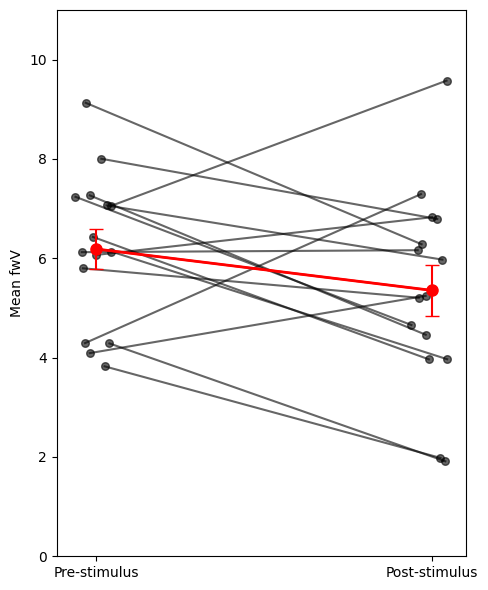

In [151]:
events_df_1, agg_df_1 = compute_event_stats_fwV_flyid_2(combined_df_MBON09, 
                                  prestim_window=(-8000,0), 
                                  poststim_window=(0,600), 
                                  fwV_bins=[0,5,float('inf')], 
                                  is_onset_col='optoStim', 
                                  flyid_col='flyid')
plot_agg_flylevel_with_line_2(agg_df_1)

In [11]:
combined_df_MBON09.flyid.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int64)

C:\Users\wilson\AppData\Local\Temp\ipykernel_13248\3576971772.py:525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_13248\3576971772.py:525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time


10
11


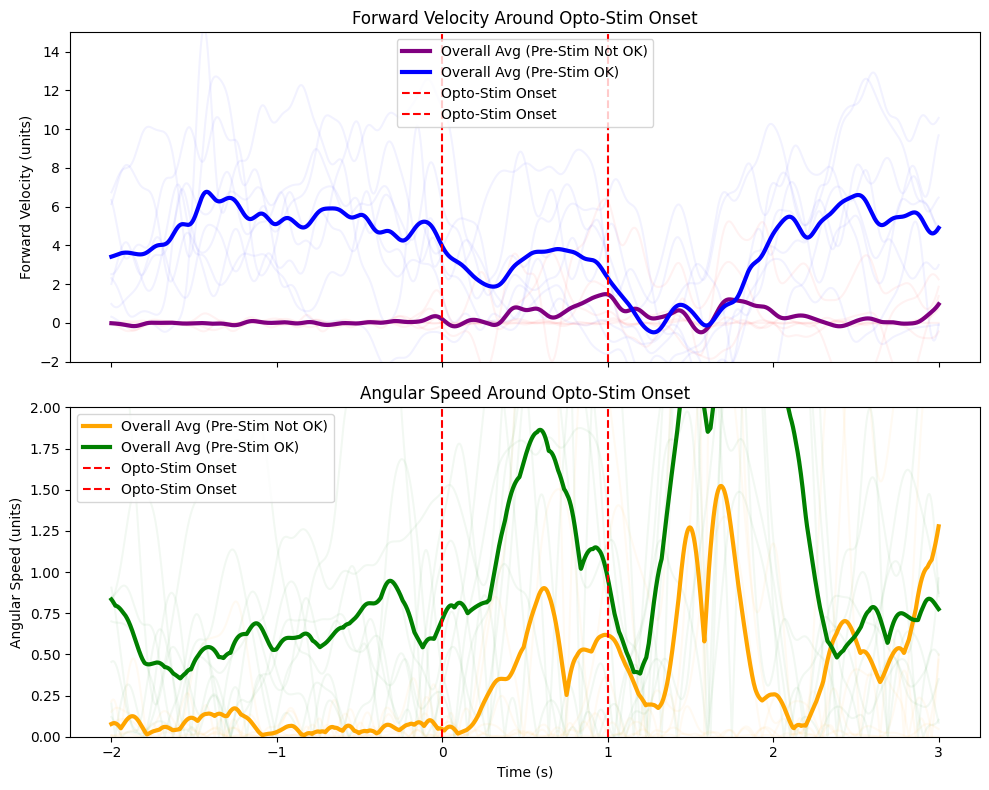

In [81]:
plot_opto_window_overlay_combined(combined_df_MBON09[combined_df_MBON09.flyid == 0])

filtered out:
- fly 0
- fly 1
- fly 3 
- fly 4 straight but a bit fragmented - check later
- fly 5 
- fly 6
 - fly 7
 - fly 8
 - fly 9 - 54
 - fly 10
 - fly 11
 - fly 12
 - fly 13
 - fly 14


In [1689]:
test = combined_df_MBON09[(combined_df_MBON09.flyid == 18) & (combined_df_MBON09.fileid == 100)]
#test.fileid.unique()



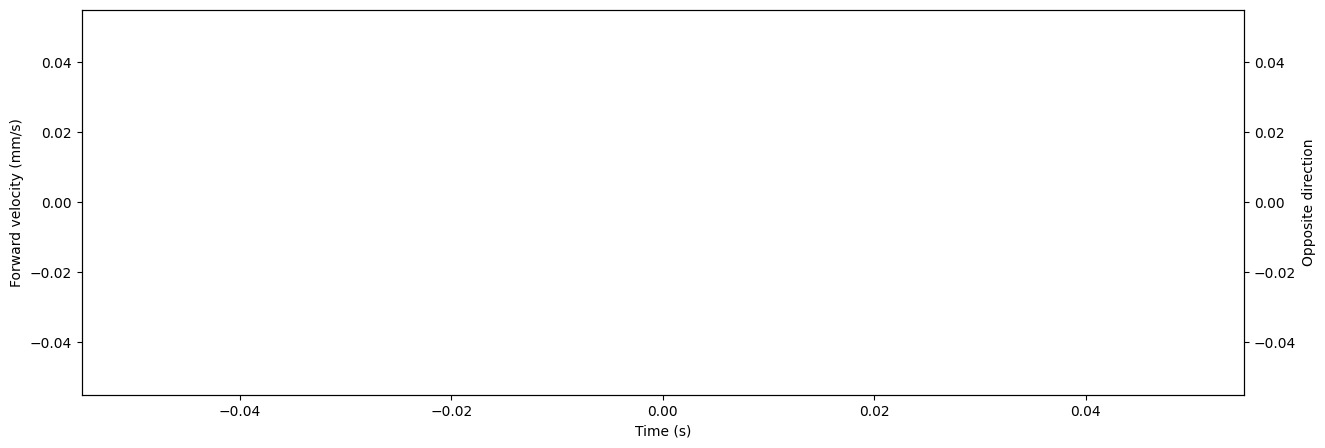

In [1690]:
fig,ax = plt.subplots(figsize=(15,5))
#ax.plot(test.tDS,test.forwardVelocity)
ax.scatter(test.tDS,test.g4displayXPos,s=1)
ax2 = ax.twinx()
ax2.plot(test.tDS,test.optoStim,color='red')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forward velocity (mm/s)')
ax2.set_ylabel('Opposite direction')
plt.show()


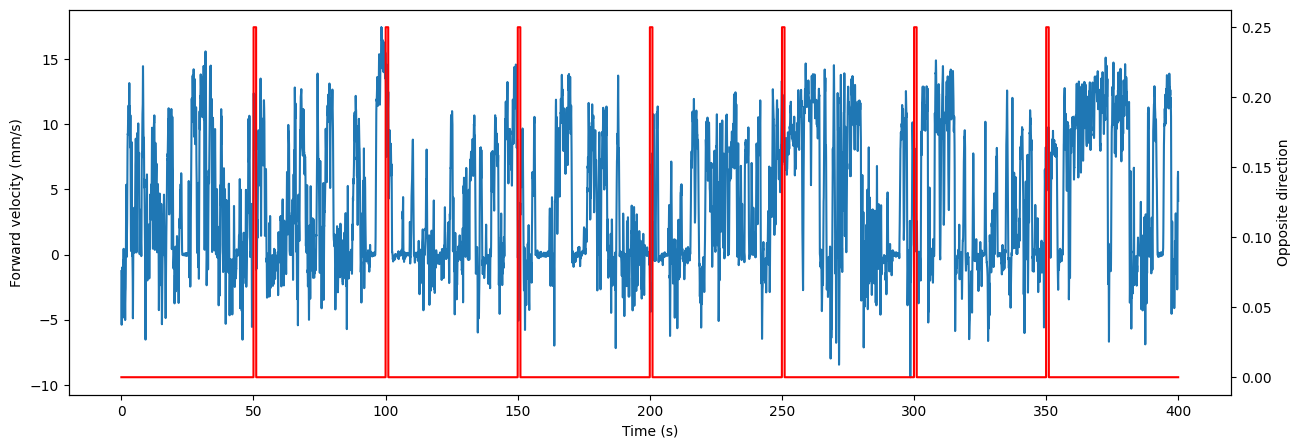

In [1686]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(test.tDS,test.forwardVelocity)
#ax.scatter(test.tDS,test.g4displayXPos,s=1)
ax2 = ax.twinx()
ax2.plot(test.tDS,test.optoStim,color='red')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forward velocity (mm/s)')
ax2.set_ylabel('Opposite direction')
plt.show()


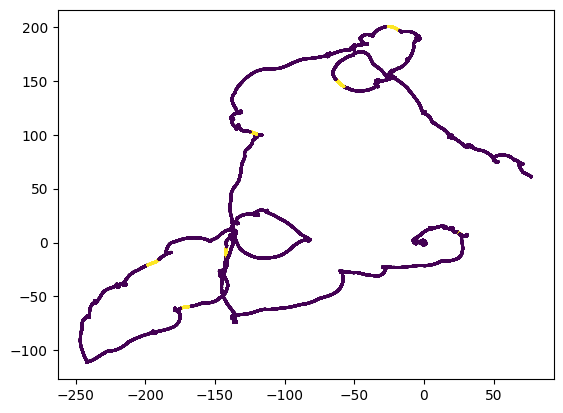

In [1682]:
plt.scatter(test.x,test.y,c=test.optoStim,s=1)

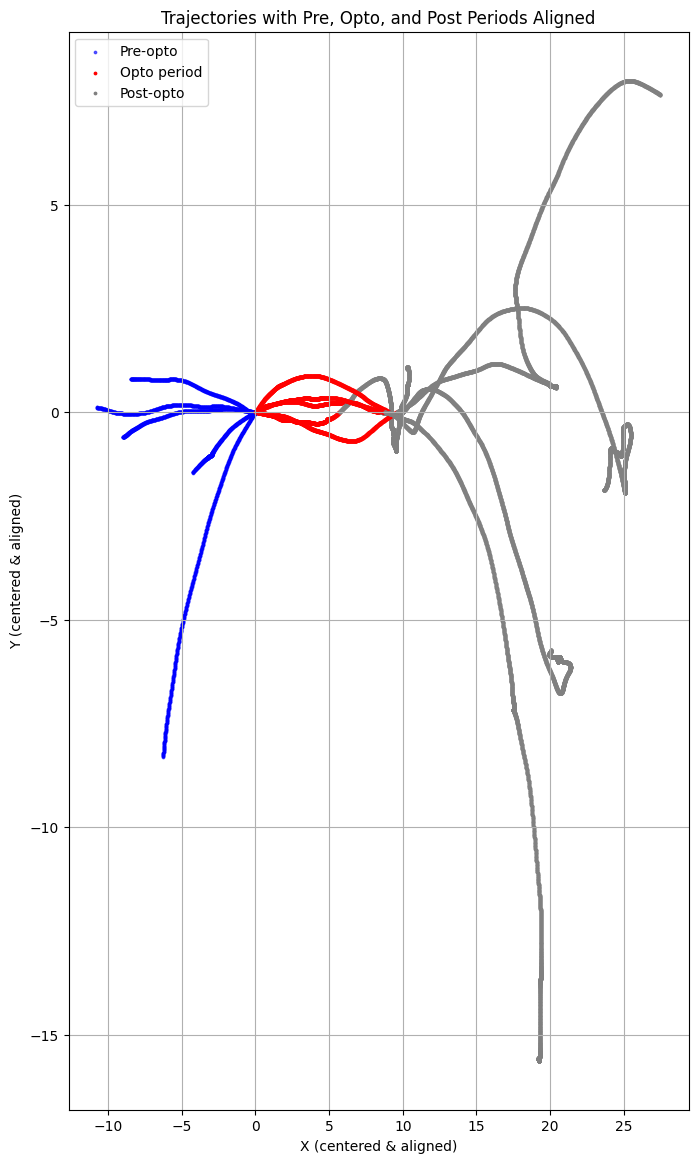

In [1683]:
plot_aligned_opto_windows(test)

#### Heading change plotting

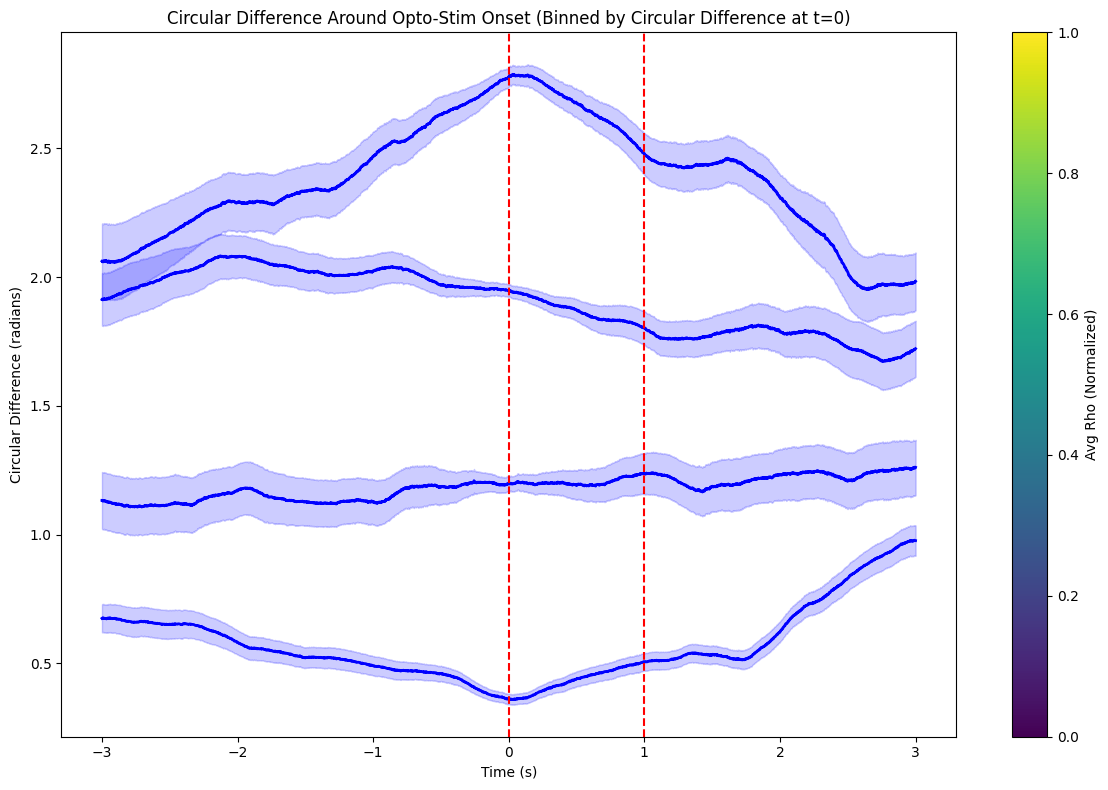

In [63]:
plot_opto_window_overlay_heading_binned(combined_df_MBON09,modal_heading_col='modal_heading', avg_rho_col='avg_rho_t',rho_threshold=0,circular_variance_threshold=0.05,n_bins=4, window=(-3, 3))

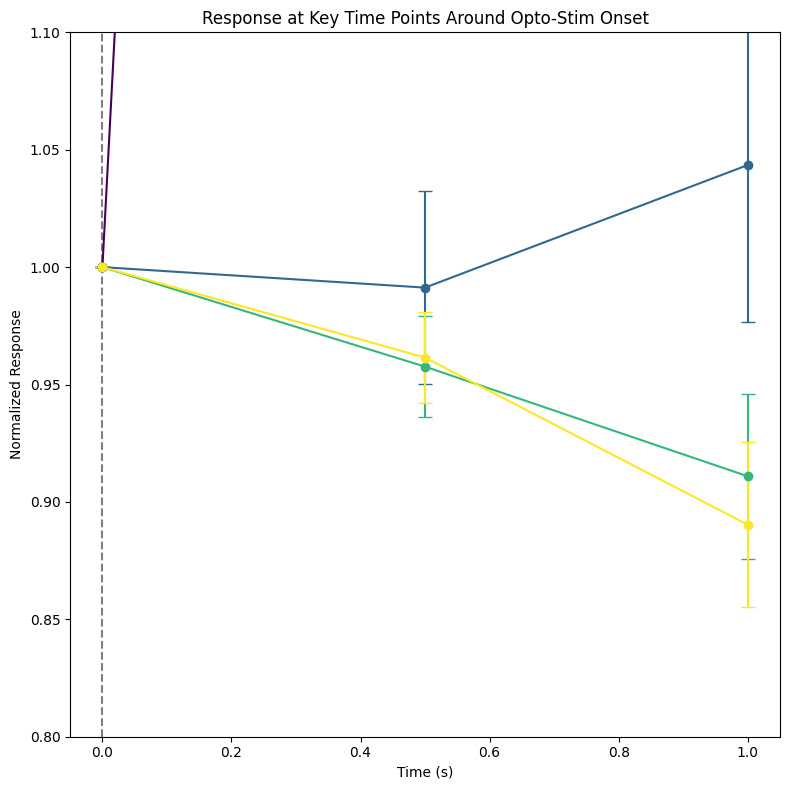

In [32]:
plot_opto_window_overlay_heading_pointavg(combined_df_MBON09,modal_heading_col='modal_heading', circular_variance_threshold=0.07,n_bins=4, window=(-3, 3),do_normalize=True)

### Chrimson control

In [26]:
folder_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_chrimson'
combined_df_ctrl = load_all_pro_mat_files_to_df(folder_path)

Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_chrimson\_2024_12_24_fly02_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_chrimson\_2024_12_24_fly04_session01_trial01A pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_chrimson\_2024_12_24_fly04_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_chrimson\_2024_12_24_fly04_session01_trial01C pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_chrimson\_2024_12_24_fly04_session01_trial01D pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.

C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\2030311375.py:2570: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = events_df.groupby(['fwV_bin', 'flyid'])


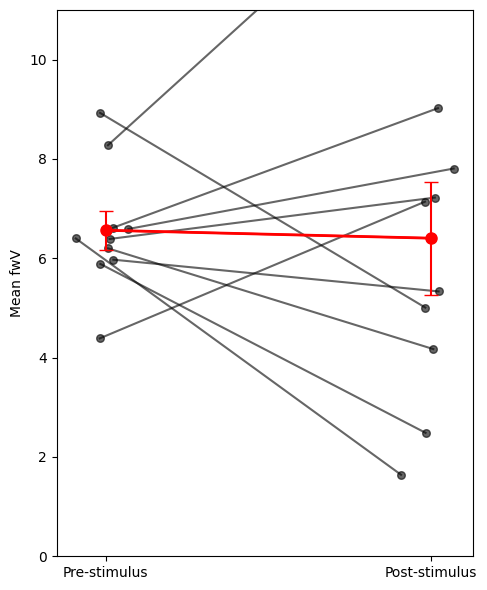

In [158]:
events_df_2, agg_df_2 = compute_event_stats_fwV_flyid(combined_df_ctrl, 
                                  prestim_window=(-8000,0), 
                                  poststim_window=(0,666), 
                                  fwV_bins=[0,4,float('inf')], 
                                  is_onset_col='optoStim', 
                                  flyid_col='flyid')

plot_agg_flylevel_with_line_2(agg_df_2)

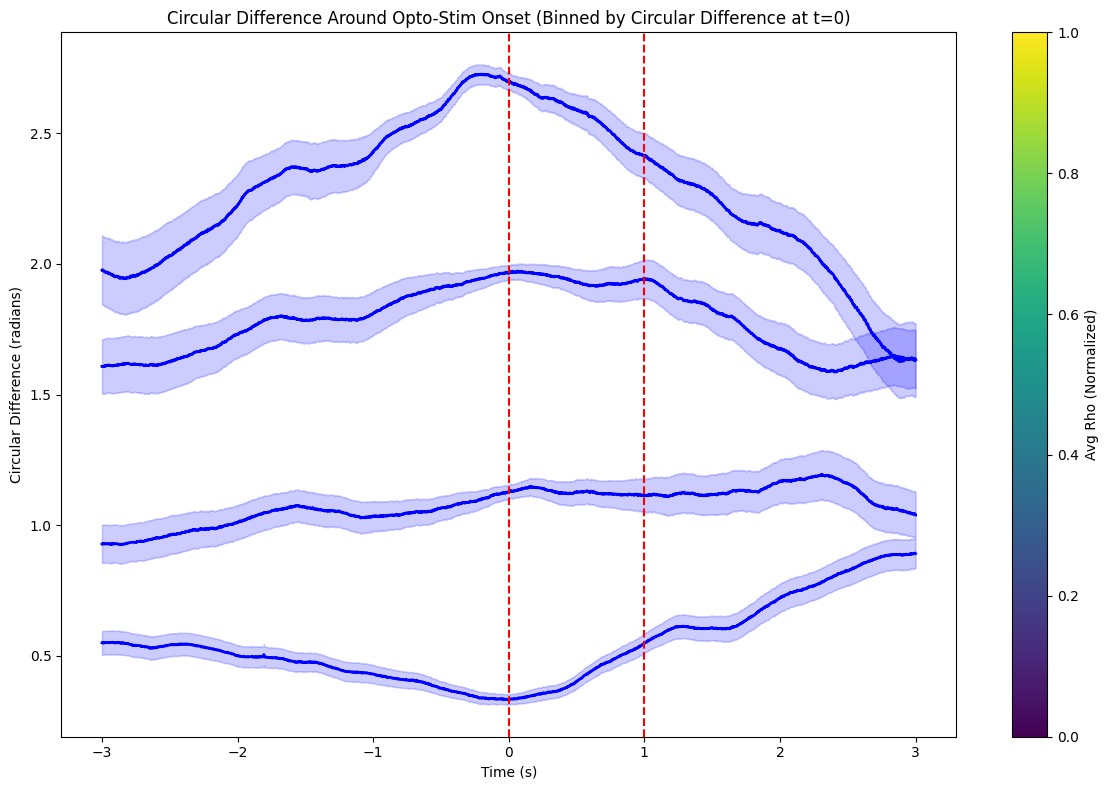

In [ ]:
plot_opto_window_overlay_heading_binned(combined_df_ctrl,avg_rho_col='avg_rho_t',rho_threshold=0,circular_variance_threshold=0.01,n_bins=4, window=(-3, 3))

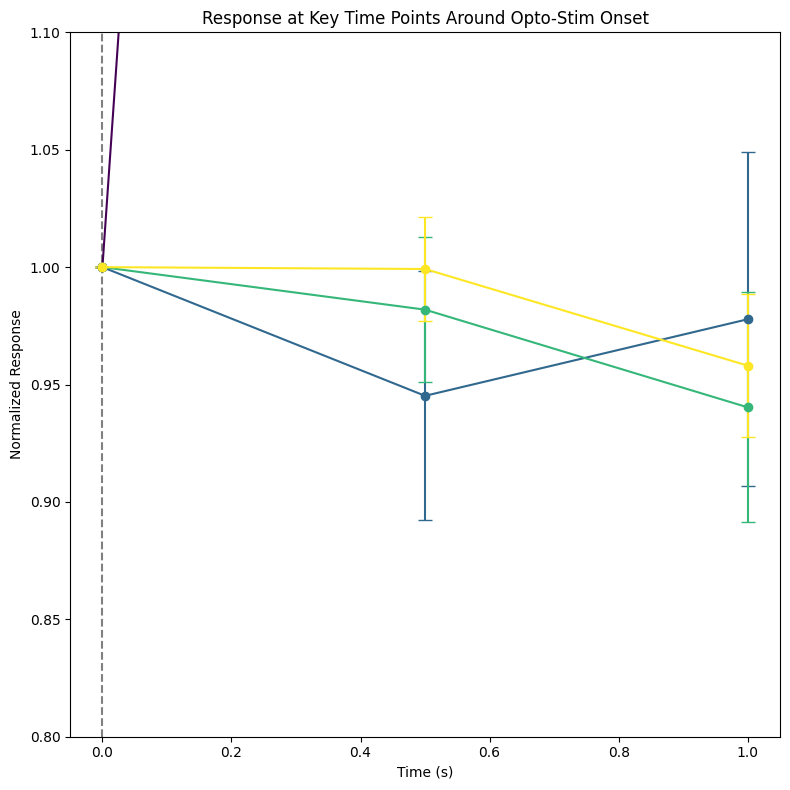

In [313]:
plot_opto_window_overlay_heading_pointavg(combined_df_ctrl,modal_heading_col='modal_heading', circular_variance_threshold=0.05,n_bins=4, window=(-3, 3),do_normalize=True)

C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_26432\3140444560.py:833: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

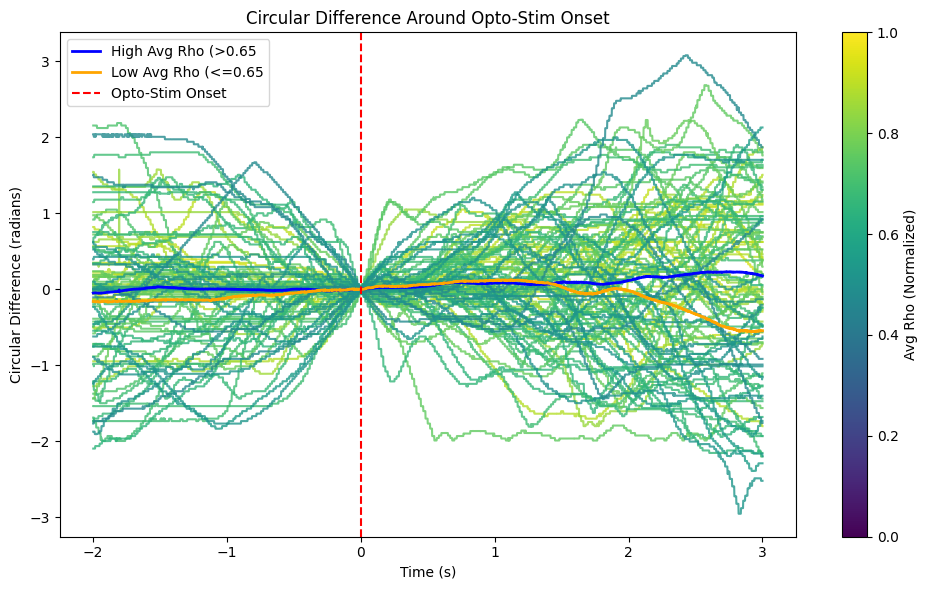

In [59]:
plot_opto_window_overlay_heading_zeroed(combined_df_ctrl,rho_threshold=0.65)

C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\2800310098.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\2800310098.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\2800310098.py:490: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

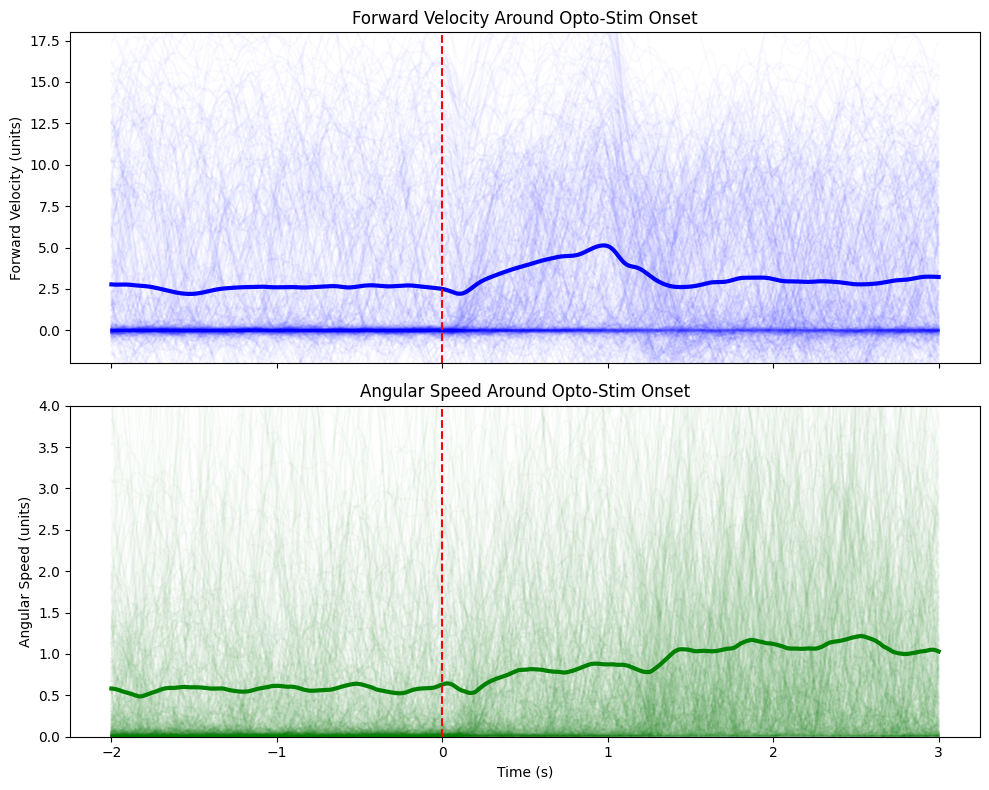

In [78]:
plot_opto_window_overlay_combined_singletrial(combined_df_ctrl)

C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\3070436038.py:642: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\3070436038.py:642: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\3070436038.py:642: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

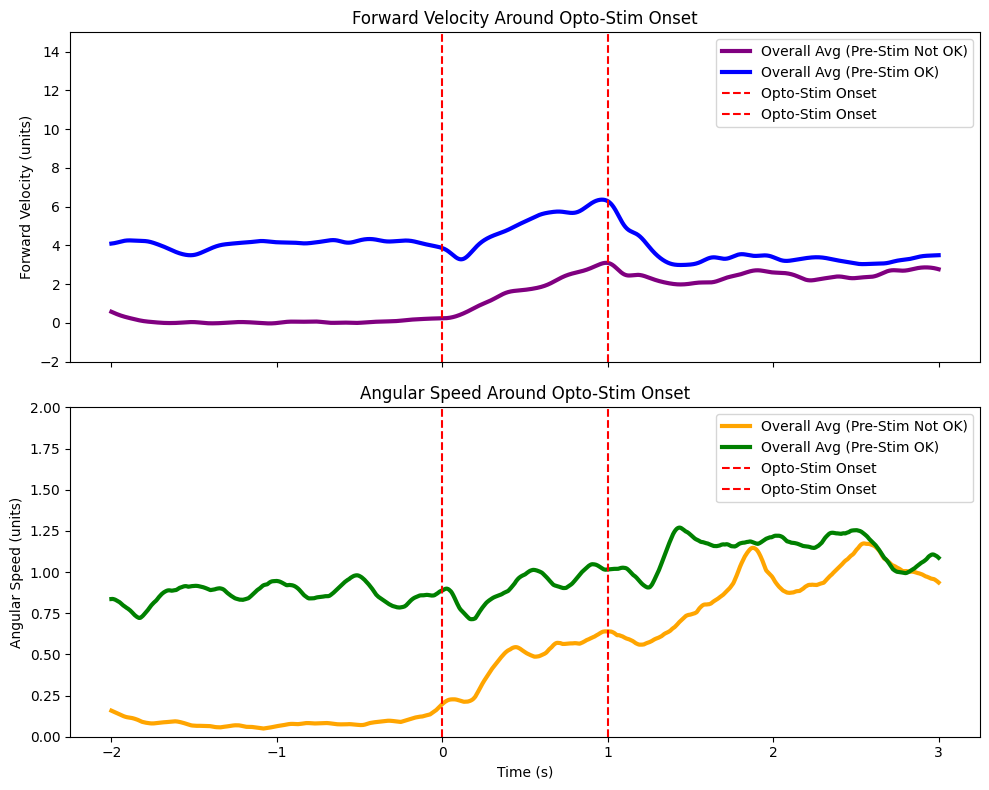

In [262]:
plot_opto_window_overlay_combined(combined_df_ctrl)

C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\137665487.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\137665487.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\137665487.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

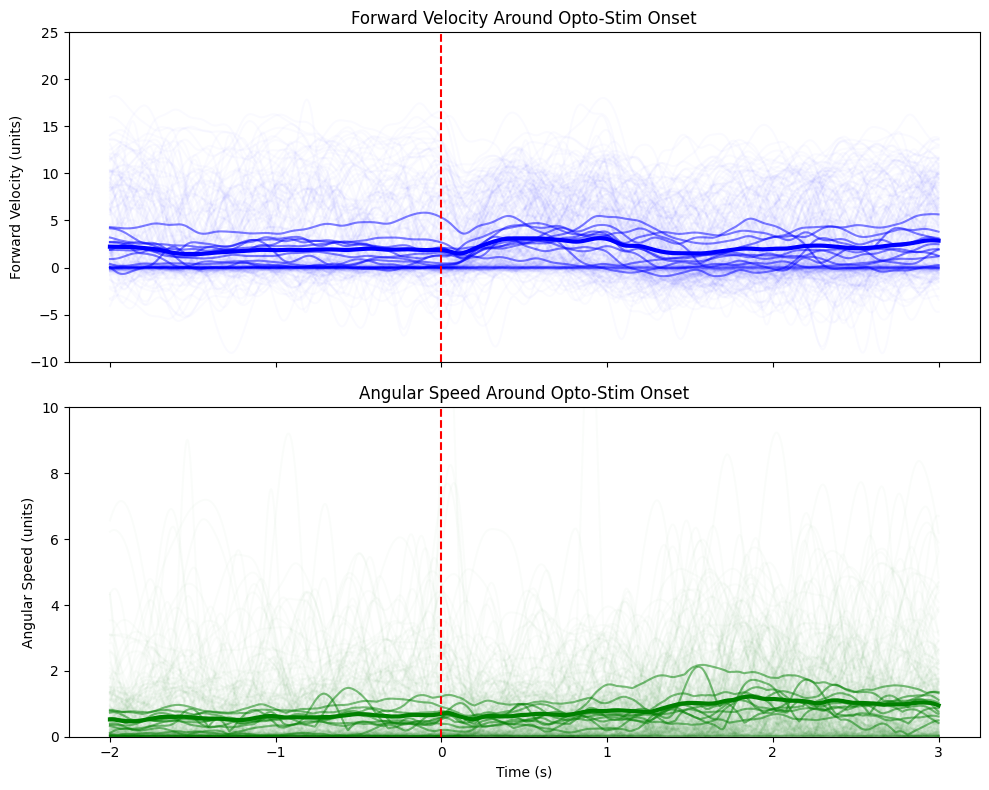

In [29]:
plot_opto_window_overlay_combined_flyavg(combined_df_ctrl)

### MBON09 control

In [173]:
# Gal4 control
folder_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_MBON09'
combined_df_ctrl_MBON09 = load_all_pro_mat_files_to_df(folder_path)

Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_MBON09\_2025_01_16_fly01_session01_trial01C pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_MBON09\_2025_01_16_fly02_session01_trial01A pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_MBON09\_2025_01_16_fly02_session01_trial01B pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_MBON09\_2025_01_16_fly02_session01_trial01C pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_control_MBON09\_2025_01_16_fly02_session01_trial01D pattern20 stim2 ftmode0_pro.mat
Loading file: //research.files.med.harvard.ed

In [174]:
combined_df_ctrl_MBON09.flyid.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

filtered:
- fly 0
- fly 1 - 2, 3, 4
- fly 2 
- fly 3 
- fly 4 
- fly 6
- fly 7
- fly 9
- fly 10
- fly 11
- fly 12
- fly 13
- fly 14
- fly 15
- fly 16 just keep 98
- fly 17
- fly 18





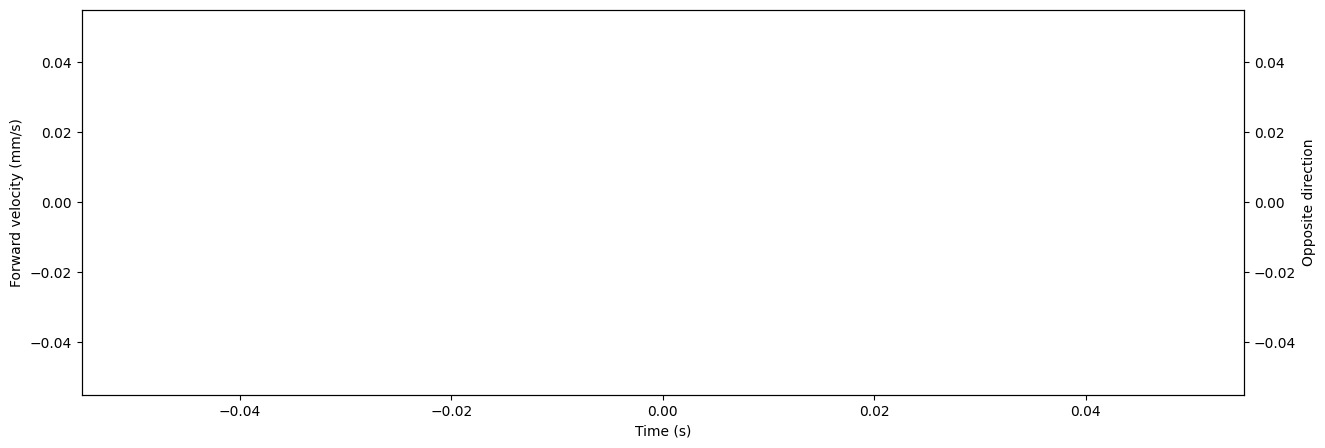

In [1845]:
test = combined_df_ctrl_MBON09[(combined_df_ctrl_MBON09.flyid == 20) & (combined_df_ctrl_MBON09.fileid == 122)]
#test.fileid.unique()

fig,ax = plt.subplots(figsize=(15,5))
ax.scatter(test.tDS,test.g4displayXPos,s=1)
ax2 = ax.twinx()
ax2.plot(test.tDS,test.optoStim,color='red')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forward velocity (mm/s)')
ax2.set_ylabel('Opposite direction')
plt.show()


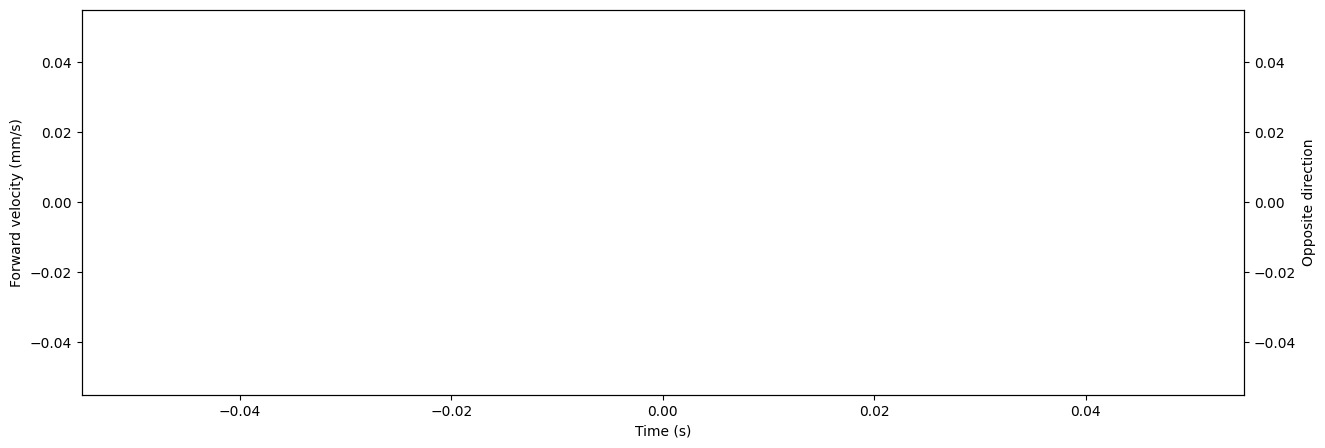

In [1846]:
#test = combined_df_ctrl_MBON09[(combined_df_ctrl_MBON09.flyid == 0) & (combined_df_ctrl_MBON09.fileid == 0)]
#test.fileid.unique()

fig,ax = plt.subplots(figsize=(15,5))
ax.plot(test.tDS,test.forwardVelocity)
ax2 = ax.twinx()
ax2.plot(test.tDS,test.optoStim,color='red')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Forward velocity (mm/s)')
ax2.set_ylabel('Opposite direction')
plt.show()


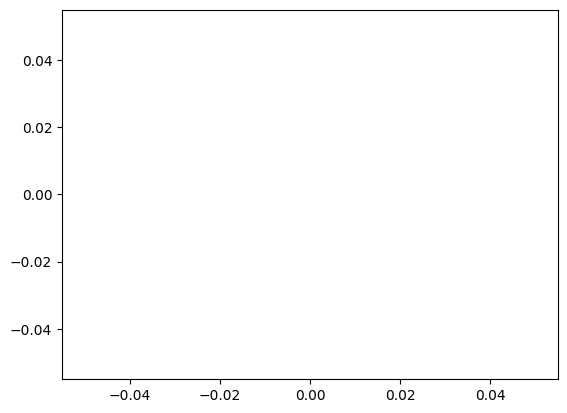

In [1844]:
plt.scatter(test.x,test.y,c=test.optoStim,s=1)

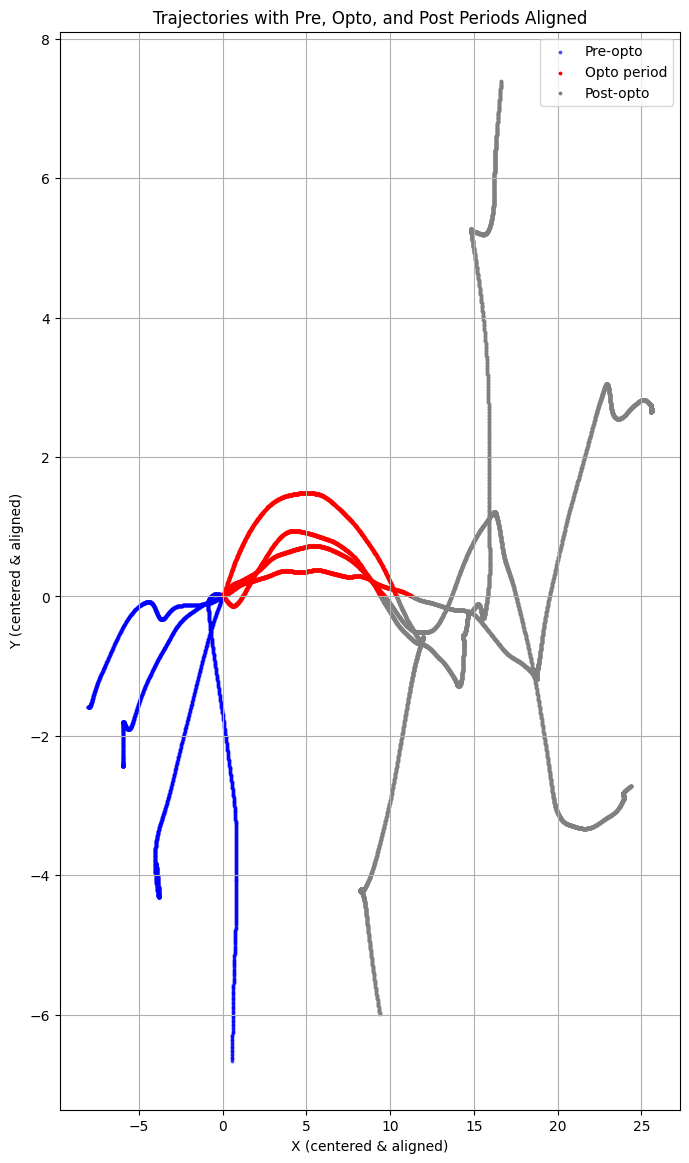

In [1838]:
plot_aligned_opto_windows(test)

C:\Users\wilson\AppData\Local\Temp\ipykernel_13248\3877688295.py:1559: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = events_df.groupby(['fwV_bin', 'flyid'])


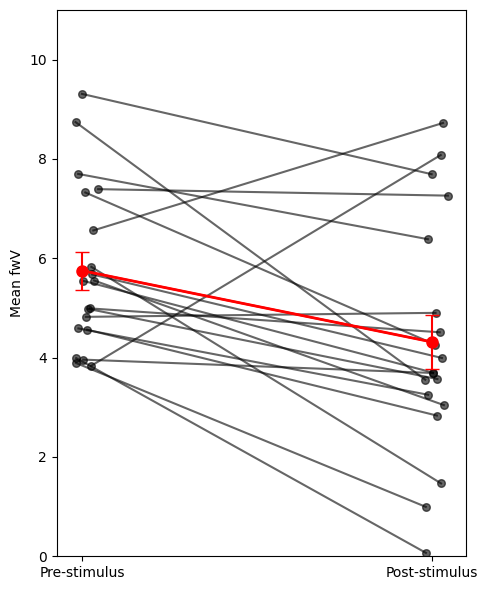

In [741]:
events_df_3, agg_df_3 = compute_event_stats_fwV_flyid(combined_df_ctrl_MBON09, 
                                  prestim_window=(-10000,0), 
                                  poststim_window=(0,600), 
                                  fwV_bins=[0,3.5,float('inf')], 
                                  is_onset_col='optoStim', 
                                  flyid_col='flyid')

plot_agg_flylevel_with_line_2(agg_df_3)

In [189]:
combined_df_ctrl_MBON09.flyid.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

notes trial to exclude:
- flyid 0

8
9


C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\3543449809.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\3543449809.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time


10
11


C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\3543449809.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\3543449809.py:507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time


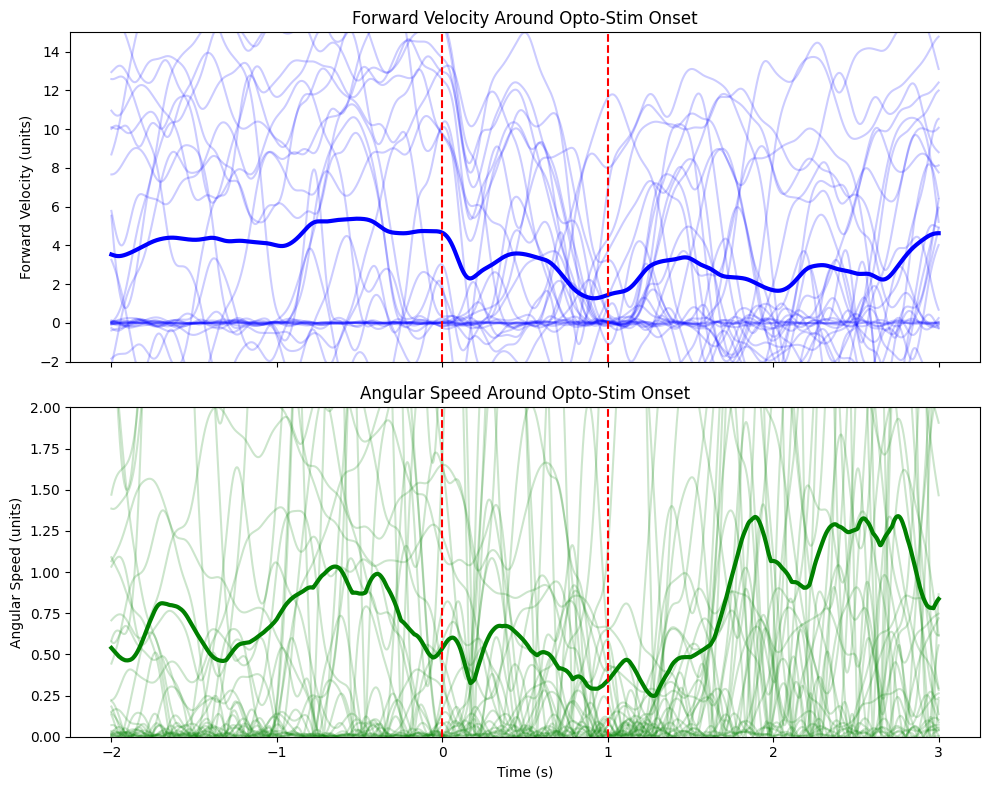

In [199]:
#plot_opto_window_overlay_combined_2(combined_df_ctrl_MBON09[combined_df_ctrl_MBON09.flyid=0])
# Fix the syntax error in the previous cell
# We need to use == for comparison, not = which is assignment
plot_opto_window_overlay_combined_singletrial(combined_df_ctrl_MBON09[combined_df_ctrl_MBON09.flyid == 2])


C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\651211160.py:646: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\651211160.py:646: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_10512\651211160.py:646: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

26
44


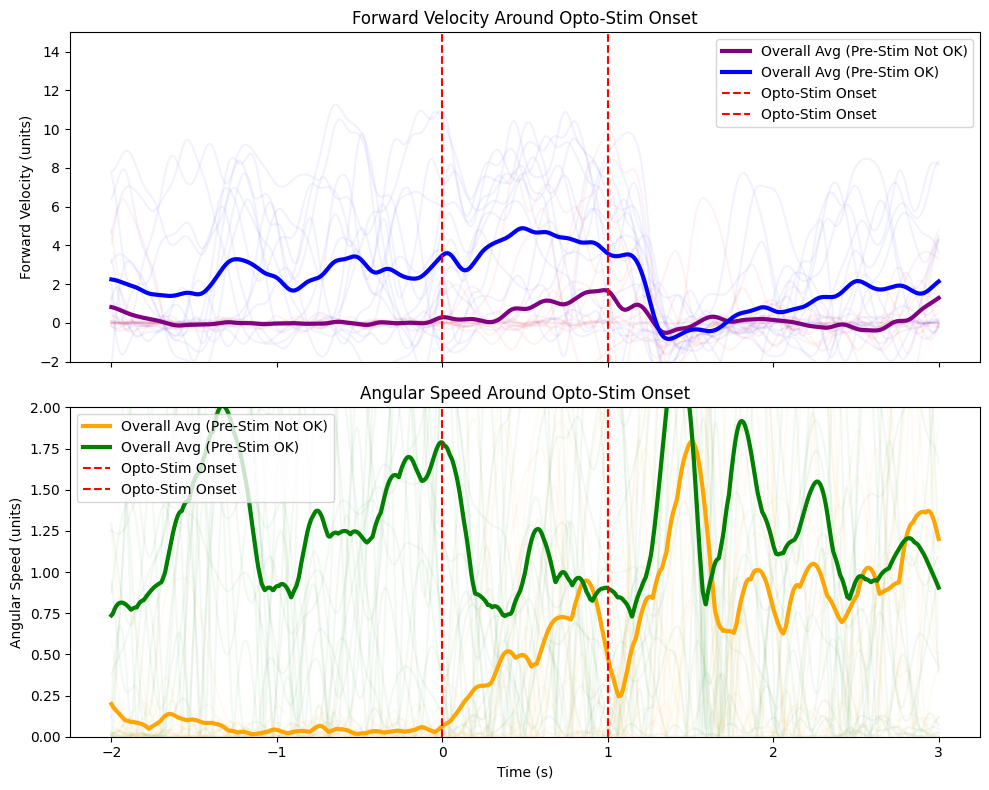

In [235]:
plot_opto_window_overlay_combined(combined_df_ctrl_MBON09[combined_df_ctrl_MBON09.flyid == 12])

C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\2573837105.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\2573837105.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aligned_time'] = df[time_col] - opto_time
C:\Users\wilson\AppData\Local\Temp\ipykernel_22604\2573837105.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

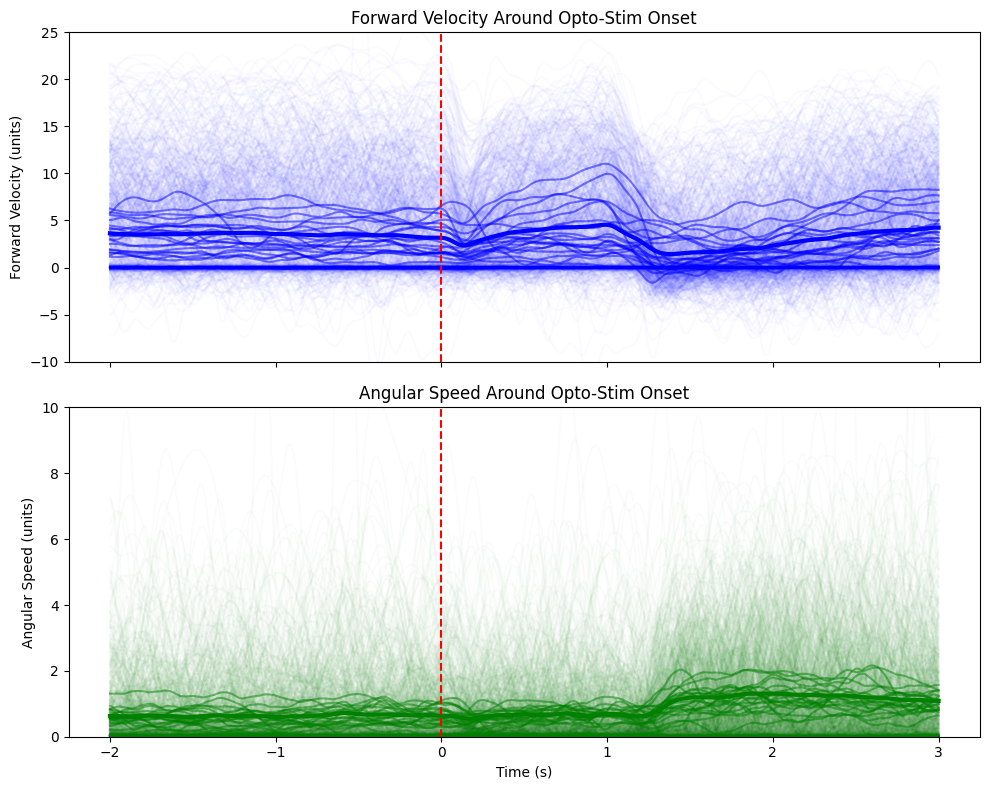

In [244]:
plot_opto_window_overlay_combined_flyavg(combined_df_ctrl_MBON09)

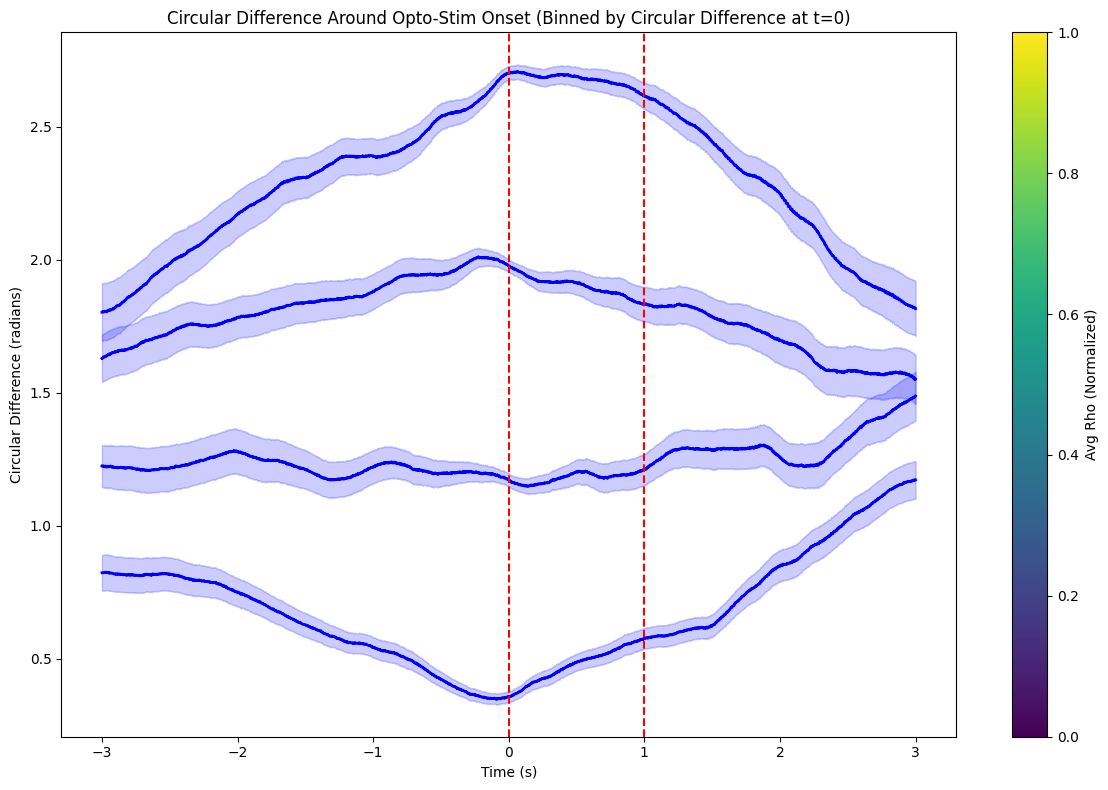

In [72]:
plot_opto_window_overlay_heading_binned(combined_df_ctrl_MBON09,avg_rho_col='avg_rho_t',rho_threshold=0,circular_variance_threshold=0.05,n_bins=4, window=(-3, 3))

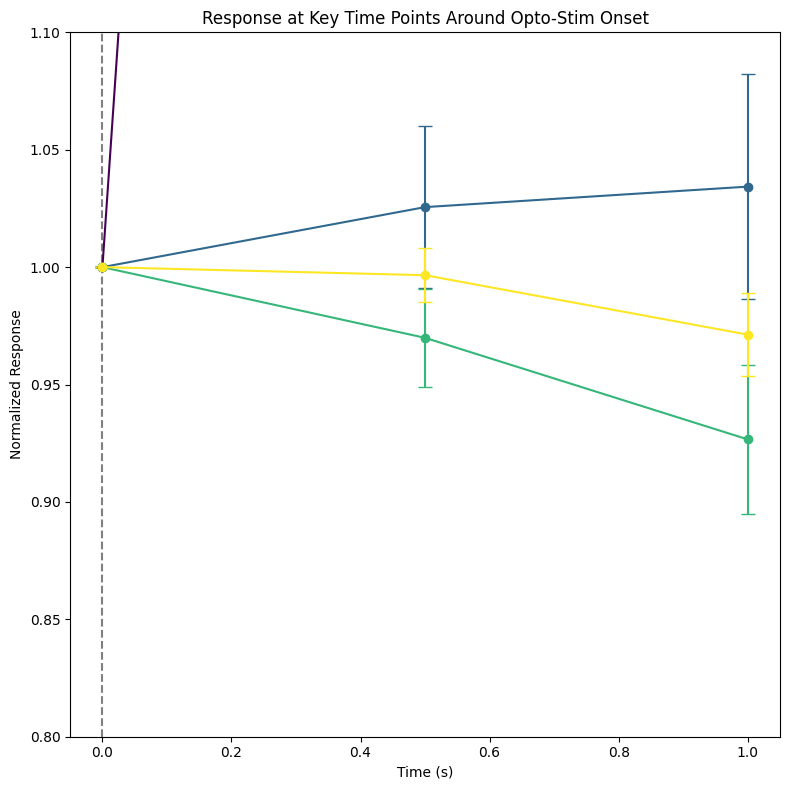

In [314]:
plot_opto_window_overlay_heading_pointavg(combined_df_ctrl_MBON09,modal_heading_col='modal_heading', circular_variance_threshold=0.05,n_bins=4, window=(-3, 3),do_normalize=True)

### Summary plotting

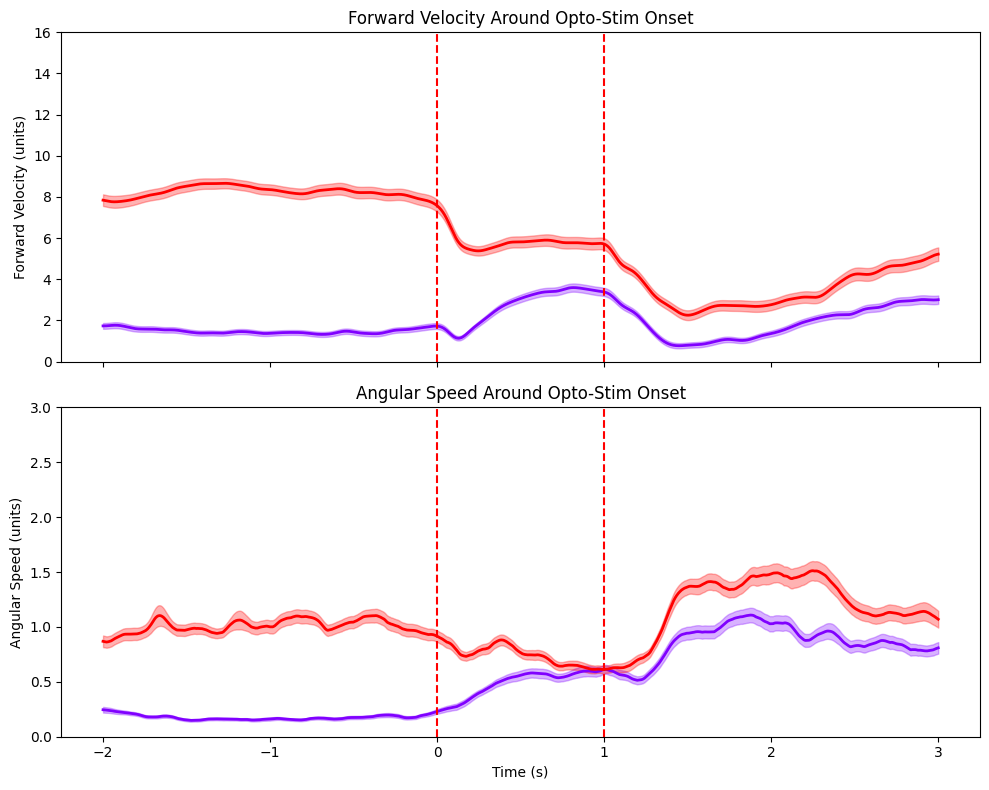

In [176]:
plot_opto_window_overlay_combined_new_0(combined_df_MBON09,forward_velocity_bounds = [0,5],angular_speed_bounds = [0, 0.5])

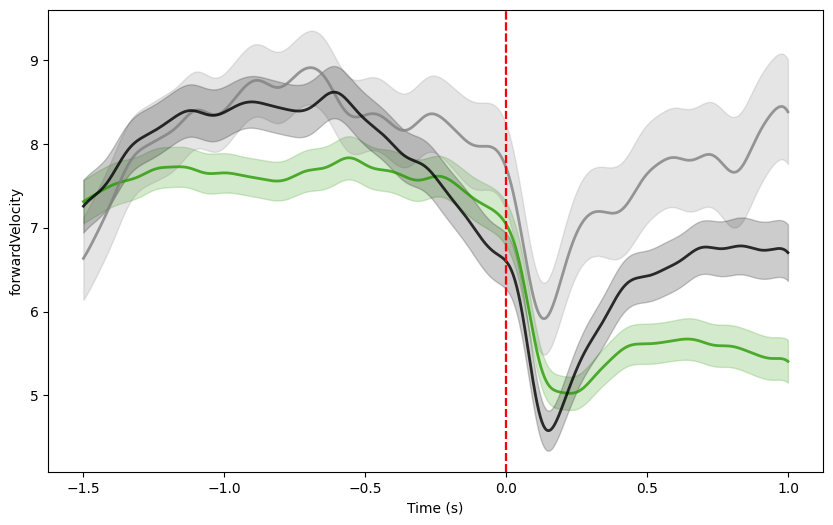

In [249]:
fig,ax = plt.subplots(figsize = (10,6))
ax = plot_forward_velocity(combined_df_MBON09,window=(-1.5,1), forward_velocity_bounds = [0,4],ax=ax)
ax = plot_forward_velocity(combined_df_ctrl,window=(-1.5,1), forward_velocity_bounds = [0,4],ax=ax,color='gray')
ax = plot_forward_velocity(combined_df_ctrl_MBON09,window=(-1.5,1), forward_velocity_bounds = [0,4],ax=ax,color='black')
#ax.set_ylim([0,16])

In [ ]:
plot_opto_dots_by_velocity_bin(
    combined_df_MBON09,
    forward_velocity_col='forwardVelocity',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    forward_velocity_bounds= [0,4,8,12,16],  # e.g., [0, 1, 2, 3]
    window_length=0.5              # length of the window in seconds (default 1 sec)
)

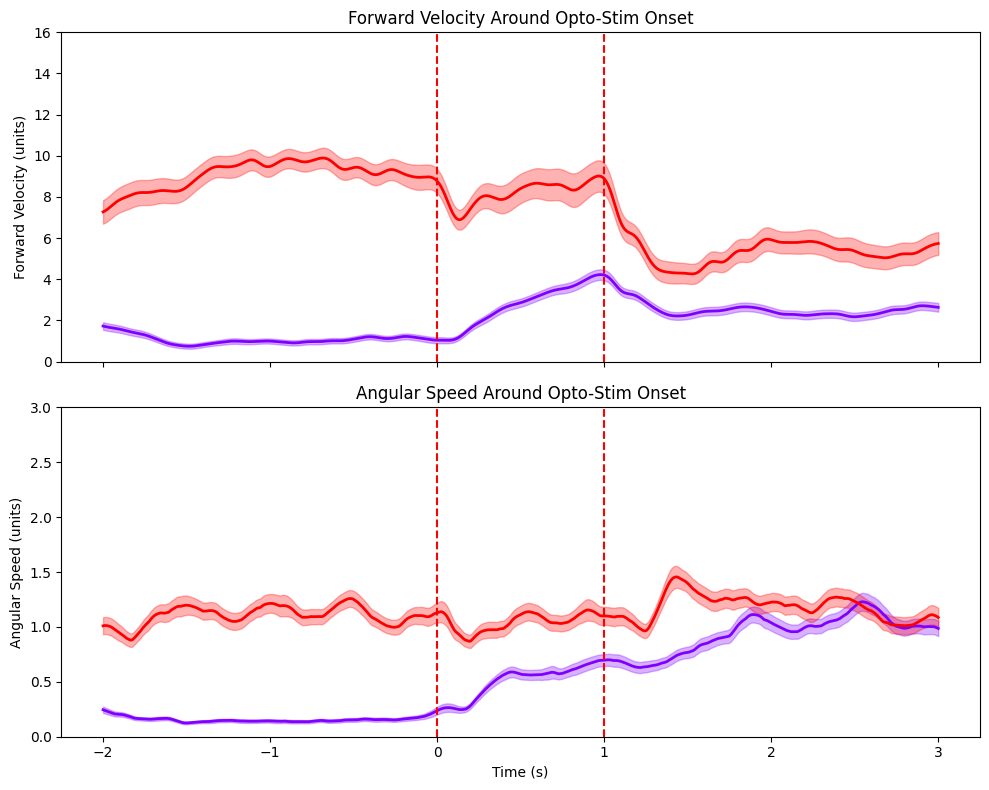

In [69]:
plot_opto_window_overlay_combined_new_0(combined_df_ctrl,forward_velocity_bounds = [0,5],angular_speed_bounds = [0, 0.5])

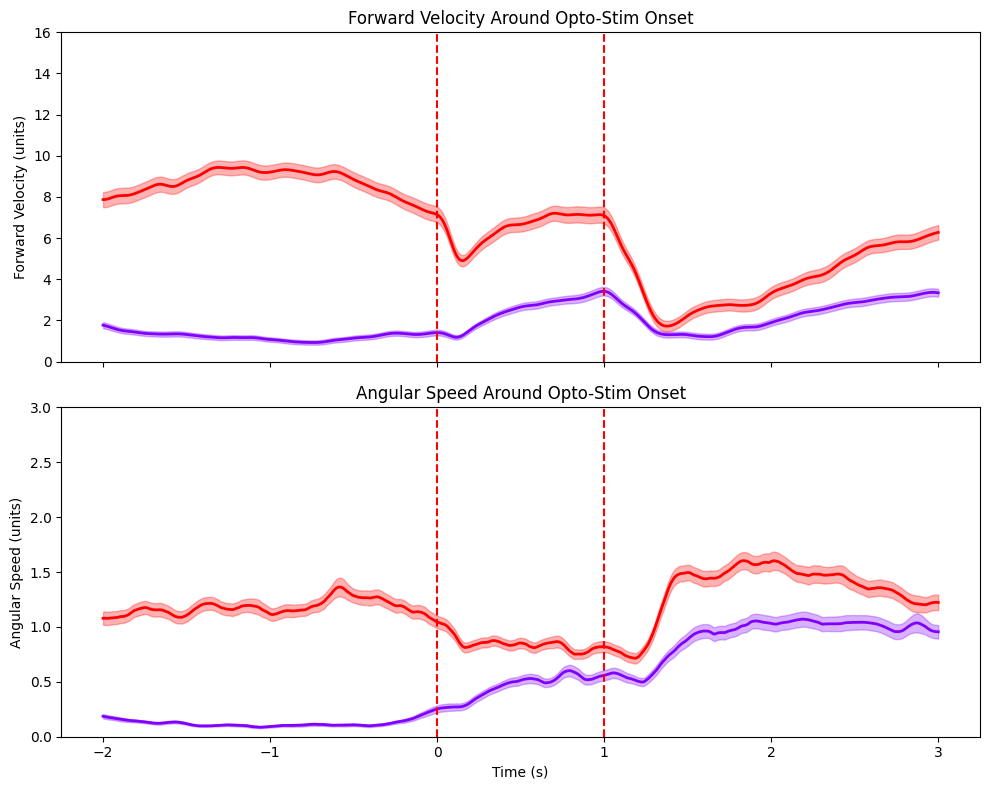

In [70]:
plot_opto_window_overlay_combined_new_0(combined_df_ctrl_MBON09,forward_velocity_bounds = [0,5],angular_speed_bounds = [0, 0.5])

In [ ]:
plot_opto_dots_by_velocity_bin(
    combined_df_ctrl_MBON09,
    forward_velocity_col='forwardVelocity',
    opto_col='optoStim',
    time_col='tDS',
    file_id_col='fileid',
    fly_id_col='flyid',
    forward_velocity_bounds= [0,4,8,12,16],  # e.g., [0, 1, 2, 3]
    window_length=0.5              # length of the window in seconds (default 1 sec)
)